# ***Data Collection***

## Unzipping all folders and subfolders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import multiprocessing

from multiprocessing.pool import ThreadPool as Pool
from datetime import timedelta, datetime
from scipy.stats import kurtosis, skew
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## First Part

In [ ]:
import os
import shutil

# Source directory for Stress Dataset
nurses_directory = r"Z:\ESSEX_Study\Decision Making\Assignment\RawData\Stress_dataset"

# Target directory for Unzipped folders
target_directory = r"Z:\ESSEX_Study\Decision Making\Assignment\Experimental_Data_Unzipped"
sub_folders = [name for name in os.listdir(nurses_directory)]


## Before running the below script make sure the target folders do not exist in the same path. Delete target folder before running this script

subFolderNames = []
deep_sub_folders = {}

## creating a list of folder names residing inside the Stress Dataset 
for i in sub_folders:
    nurse_dir = nurses_directory + '\\'+i
    deep_sub_folders[i]= [name for name in os.listdir(nurse_dir)]
    
## unzipping all the sub-folders(named as UNIX timestamp) created against each subject(Nurse)
for k,v in deep_sub_folders.items():
    count = 0
    for ele in deep_sub_folders[k]:
        source = nurses_directory+'\\'+k+'\\'+ele
        target = target_directory+'\\'+k+'\\'+ele
        print(source)
        print(target+'\n')
        shutil.unpack_archive(source, target, 'zip')
        count = count + 1

### Combining the signals into signal specific files respectively
### _(Code referenced shared by authors)_

In [ ]:
# Script to combine all signals into one

import os
import pandas as pd
import numpy as np
import multiprocessing
from multiprocessing.pool import ThreadPool as Pool
from datetime import timedelta, datetime

DATA_PATH = "F:\Assignment\Experimental_Data_Unzipped"
SAVE_PATH = "E:\Assignment\processed_data2_Unzipped"
os.mkdir(SAVE_PATH)

# initializing dictionary with desired column names for the final version of each signal file
final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
}

# initializing dictionary with feature names for each signal file
names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP'],
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']

# creating blank dataframes for each type of signal with finalized column names
acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])

# function to process the initial two rows(Timestamp and sampling rate) of each files
# and create dataframe with the actual signal values
def process_df(df, file):
    start_timestamp = df.iloc[0,0]
    sample_rate = df.iloc[1,0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] =  file[-2:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    return new_df

# creating dataframes for desired signals by combining all files
for file in os.listdir(DATA_PATH):
    print(f'Processing {file}')
    for sub_file in os.listdir(os.path.join(DATA_PATH, file)):
        if sub_file.endswith(".zip"):
            for signal in os.listdir(os.path.join(DATA_PATH, file, sub_file)):
                if signal in desired_signals:
                    df = pd.read_csv(os.path.join(DATA_PATH, file, sub_file, signal), names=names[signal], header=None)
                    if not df.empty:
                        if signal == 'ACC.csv':
                            acc = pd.concat([acc, process_df(df, file)])             
                        if signal == 'EDA.csv':
                            eda = pd.concat([eda, process_df(df, file)])
                        if signal == 'HR.csv':
                            hr = pd.concat([hr, process_df(df, file)])
                        if signal == 'TEMP.csv':
                            temp = pd.concat([temp, process_df(df, file)])

print('Saving Data ...')
# converting and saving signal dataframes to desired locations
acc.to_csv(os.path.join(SAVE_PATH, 'combined_acc.csv'), index=False)
eda.to_csv(os.path.join(SAVE_PATH, 'combined_eda.csv'), index=False)
hr.to_csv(os.path.join(SAVE_PATH, 'combined_hr.csv'), index=False)
temp.to_csv(os.path.join(SAVE_PATH, 'combined_temp.csv'), index=False)


Processing 15
Processing 5C
Processing 6B
Processing 6D
Processing 7A
Processing 7E
Processing 83
Processing 8B
Processing 94
Processing BG
Processing CE
Processing DF
Processing E4
Processing EG
Processing F5
Saving Data ...


## Merging all the signal specific files into a single file (merging features)
### _(Code referenced shared by authors)_

In [ ]:
COMBINED_DATA_PATH = "E:\Assignment\processed_data2_Unzipped"

SAVE_PATH = "E:\Assignment\MergedData"

if COMBINED_DATA_PATH != SAVE_PATH:
    os.mkdir(SAVE_PATH)

print("Reading data ...")

acc, eda, hr, temp = None, None, None, None

signals = ['acc', 'eda', 'hr', 'temp']

## Reading all the signal files parallelly with Multiprocessing pool
def read_parallel(signal):
    df = pd.read_csv(os.path.join(COMBINED_DATA_PATH, f"combined_{signal}.csv"), dtype={'id': str})
    return [signal, df]

pool = Pool(len(signals))
results = pool.map(read_parallel, signals)
pool.close()
pool.join()


for i in results:
    globals()[i[0]] = i[1]

# Merging data
print('Merging Data ...')
ids = eda['id'].unique()
columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime']


# Merging files through outer join depending on datetime and filling up Nan values by forward fill and backward fill strategy
def merge_parallel(id):
    print(f"Processing {id}")
    df = pd.DataFrame(columns=columns)
    
    acc_id = acc[acc['id'] == id]
    eda_id = eda[eda['id'] == id].drop(['id'], axis=1)
    hr_id = hr[hr['id'] == id].drop(['id'], axis=1)
    temp_id = temp[temp['id'] == id].drop(['id'], axis=1)

    df = acc_id.merge(eda_id, on='datetime', how='outer')
    df = df.merge(temp_id, on='datetime', how='outer')
    df = df.merge(hr_id, on='datetime', how='outer')

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df




pool = Pool(len(ids))
results = pool.map(merge_parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print("Saving data ...")

# Saving the Merged Dataset
new_df.to_csv(os.path.join(SAVE_PATH, "merged_data.csv"), index=False)


Reading data ...
Merging Data ...
Processing 15
Processing 5C
Processing 6B
Processing 6D
Processing 7A
Processing 7E
Processing 83
Processing 8B
Processing 94
Processing BG
Processing CE
Processing DF
Processing E4
Processing EG
Processing F5
Saving data ...


## Labelling the merged dataset with the help survey results
### _(Code referenced shared by authors)_

In [ ]:
!pip install openpyxl
!pip install xlwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 9.3 MB/s eta 0:00:00


# ***Exploratory Data Analysis***

In [ ]:
# Read Files
print("Reading 1 ...")
PATH = "E:\Assignment\MergedData"

df = pd.read_csv(os.path.join(PATH, 'merged_data.csv'), dtype={'id': str})
df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x * (10 ** 9)))

print("Reading 2 ...")
survey_path = "E:\Assignment\SurveyResults.xlsx"

survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str},engine = 'openpyxl')
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)

survey_df['Start datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['Start time'].map(str))
survey_df['End datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['End time'].map(str))
survey_df.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
print("Converting ...")
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey_df1 = survey_df[survey_df['End datetime'] <= daylight].copy()
survey_df1['Start datetime'] = survey_df1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_df1['End datetime'] = survey_df1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_df2 = survey_df.loc[survey_df['End datetime'] > daylight].copy()
survey_df2['Start datetime'] = survey_df2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_df2['End datetime'] = survey_df2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_df = pd.concat([survey_df1, survey_df2], ignore_index=True)
# survey_df = survey_df.loc[survey_df['Stress level'] != 1.0]

survey_df.reset_index(drop=True, inplace=True)

# Label Data
print('Labelling ...')
ids = df['id'].unique()

def parallel(id):
    new_df = pd.DataFrame(columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'])

    sdf = df[df['id'] == id].copy()
    survey_sdf = survey_df[survey_df['ID'] == id].copy()

    for _, survey_row in survey_sdf.iterrows():
        ssdf = sdf[(sdf['datetime'] >= survey_row['Start datetime']) & (sdf['datetime'] <= survey_row['End datetime'])].copy()

        if not ssdf.empty:
            ssdf['label'] = np.repeat(survey_row['Stress level'], len(ssdf.index))
            new_df = pd.concat([new_df, ssdf], ignore_index=True)
        else:
            print(f"{survey_row['ID']} is missing label {survey_row['Stress level']} at {survey_row['Start datetime']} to {survey_row['End datetime']}")
        
    return new_df

pool = Pool(len(ids))
results = pool.map(parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print('Saving ...')
new_df.to_csv(os.path.join(PATH, 'merged_data_labeled.csv'), index=False)
print('Done')

Reading 1 ...
Reading 2 ...
Converting ...
Labelling ...
6D is missing label 1.0 at 2020-06-03 07:00:00 to 2020-06-03 09:00:00
8B is missing label 2.0 at 2020-07-13 16:59:00 to 2020-07-13 17:05:00
5C is missing label 1.0 at 2020-04-15 13:00:00 to 2020-04-15 14:00:00
83 is missing label 2.0 at 2020-10-28 08:20:00 to 2020-10-28 08:52:00
83 is missing label 0.0 at 2020-10-28 09:44:00 to 2020-10-28 10:05:00
94 is missing label 1.0 at 2020-05-10 13:06:00 to 2020-05-10 13:38:00
EG is missing label 2.0 at 2020-11-08 19:30:00 to 2020-11-08 20:00:00
BG is missing label 0.0 at 2020-11-05 06:15:00 to 2020-11-05 06:17:00
8B is missing label 2.0 at 2020-07-17 13:57:00 to 2020-07-17 14:04:00
8B is missing label 2.0 at 2020-07-17 14:14:00 to 2020-07-17 14:30:00
8B is missing label 0.0 at 2020-07-17 15:10:00 to 2020-07-17 15:34:00
8B is missing label 2.0 at 2020-07-20 14:50:00 to 2020-07-20 15:48:0094 is missing label 1.0 at 2020-06-24 18:50:00 to 2020-06-24 19:15:00

5C is missing label 0.0 at 2020-0

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Checking how each subjects is experiencing different levels of Stress

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 20 columns):
 #   Column                                                                   Non-Null Count  Dtype         
---  ------                                                                   --------------  -----         
 0   ID                                                                       358 non-null    object        
 1   Start time                                                               358 non-null    object        
 2   End time                                                                 358 non-null    object        
 3   duration                                                                 358 non-null    object        
 4   date                                                                     358 non-null    datetime64[ns]
 5   Stress level                                                             358 non-null    object        
 6   COVID related     

<ipython-input-1-f845e98561aa>:41: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  survey_cpy.to_excel('/content/drive/MyDrive/DSDM_Temp/Output_survey.xls')


Text(0, 0.5, 'Stress Duration')

<Figure size 1500x1000 with 0 Axes>

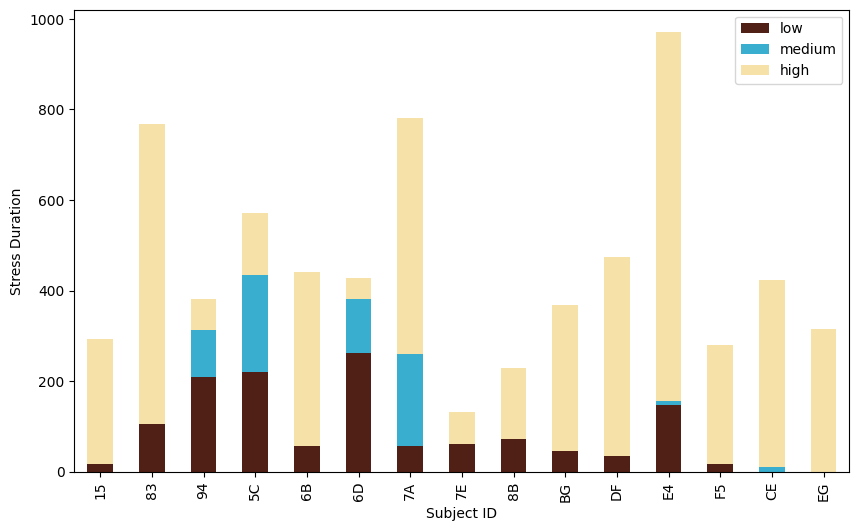

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy


# reading survey result Dataset
survey = pd.read_excel("/content/drive/MyDrive/DSDM_Temp/SurveyResults.xlsx", engine = 'openpyxl')

# checking information about the dataset
survey.info()


# checking the null values present in the dataset
survey.isnull().sum()

# first replacing the 'na' string with np.NaN
survey = survey.replace('na', np.NaN)


# considering the records where Na values are not present and making a copy 
survey = survey[survey['Stress level'].notna()]
survey_cpy = copy.copy(survey)


# rearranging the index of removing nulls
survey_cpy.reset_index()

# function to convert time duration in minutes
def to_minute(stress_time):
    return stress_time.hour * 60 + stress_time.minute


# applying the function on the duration column
survey_cpy['duration'] = survey_cpy['duration'].map(to_minute)


# saving processed file
survey_cpy.head(2)
survey_cpy.to_excel('/content/drive/MyDrive/DSDM_Temp/Output_survey.xls')


# creating dataframes of total stress durations experienced by each subject based on different levels of stress
plt.figure(figsize=(15,10))
survey_duration = survey_cpy.loc[:,['ID','duration']]
low = survey_duration[survey_cpy['Stress level']==0].groupby('ID').sum().reset_index()
medium = survey_duration[survey_cpy['Stress level']==1].groupby('ID').sum().reset_index()
high = survey_duration[survey_cpy['Stress level']==2].groupby('ID').sum().reset_index()
mergedSurvey = pd.merge(low, medium , on = 'ID', how= 'outer')
mergedSurvey = pd.merge(mergedSurvey, high , on = 'ID', how= 'outer').replace(np.NaN, 0)


mergedSurvey = mergedSurvey.set_index('ID')
mergedSurvey.columns = ['low','medium','high']

# plotting the bar plot for Subject ID vs Total Stress duration(based on different levels of stress)
mergedSurvey.plot.bar(stacked = True, color = {'#f6e1a9','#39aecf','#501f15'},figsize= (10,6)).legend(loc=1)
plt.xlabel('Subject ID')
plt.ylabel('Stress Duration')


#### The below barplot exhibits the duration of each type of stress level experienced by each of the nurses. We can easily say that subject 83, E4 suffers the longest duration of stress level 2. Few subjects have never experienced medium stress level.

### Exploring the Labeled dataset with graphs and plots

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import os
sns.set_style("darkgrid")

In [ ]:
# function for converting datatimestamps into unix date format

def to_unix_time(val):
    val =  str(val)
    val = val[:-3]
    date = datetime.datetime.strptime(val, '%Y-%m-%d %H:%M:%S.%f')
    unix_format_date = date.timestamp()
    return unix_format_date

In [82]:
# reading the labeled dataset

data1 = pd.read_csv("/content/drive/MyDrive/DSDM_Temp/merged_data_labeled.csv")

<ipython-input-82-af874a7fd158>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv("/content/drive/MyDrive/DSDM_Temp/merged_data_labeled.csv")


In [83]:
# mapping the labels of labeled dataset with string values (categorical variable)

data = data1.copy()  #Creating copy of the data
map_label = {0.0:'0', 1.0:'1', 2.0:'2'}
data['label'] = data['label'].map(map_label)

In [84]:
# mapping the subject ids with string values (categorical variable)

map_id_correction = {15:'15', 94:'94', 83:'83'}
data['id'] = data['id'].replace(map_id_correction)

In [85]:
data['id'].unique()

array(['15', '5C', '6B', '6D', '7A', '7E', '83', '8B', '94', 'BG', 'CE',
       'DF', 'E4', 'EG', 'F5'], dtype=object)

In [86]:
# merging two stress labels
participant_list = list(data['id'].unique())
data2 = data.copy()
StressedOrNot = {'2':'1'}
data2['label'] = data2['label'].replace(StressedOrNot)

In [ ]:
data2['label'].unique()

array(['1', '0'], dtype=object)


### HR comparison

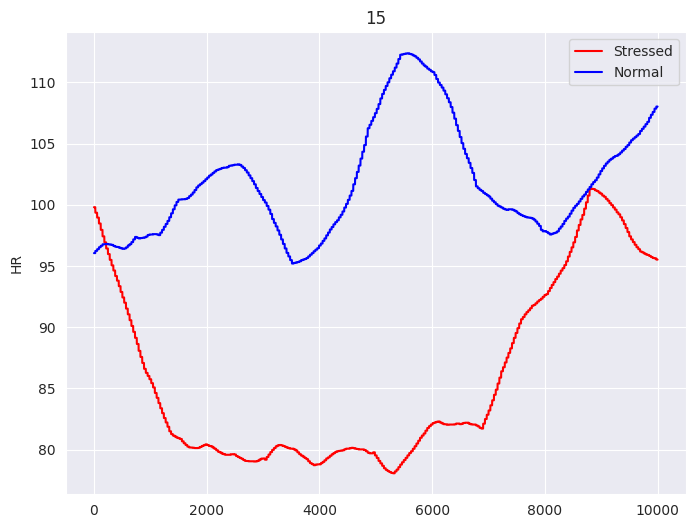

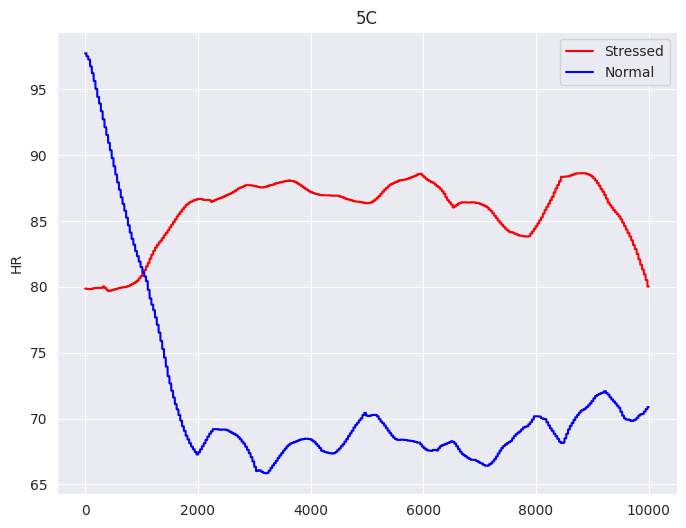

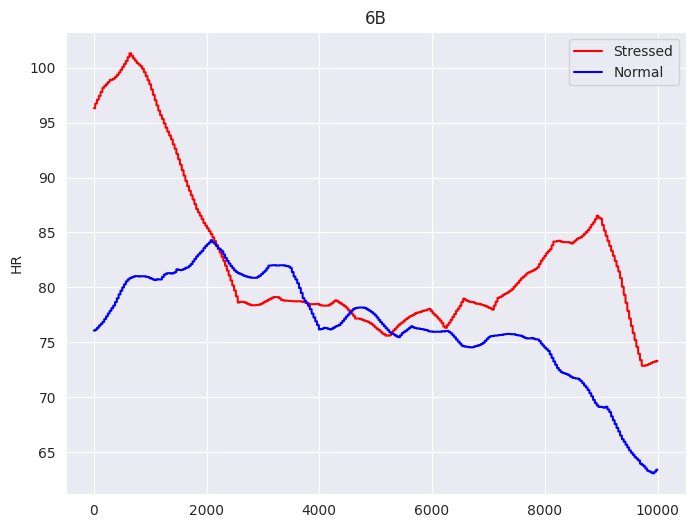

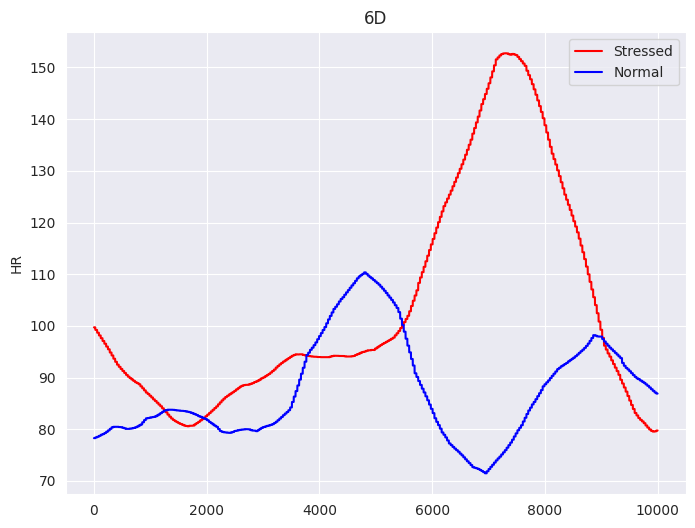

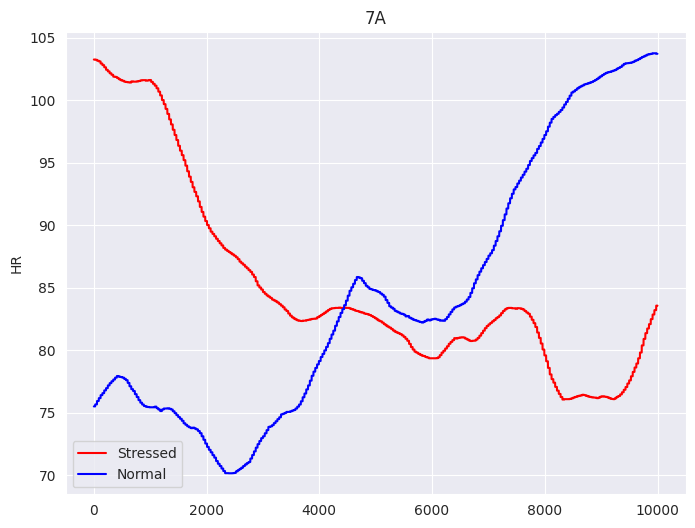

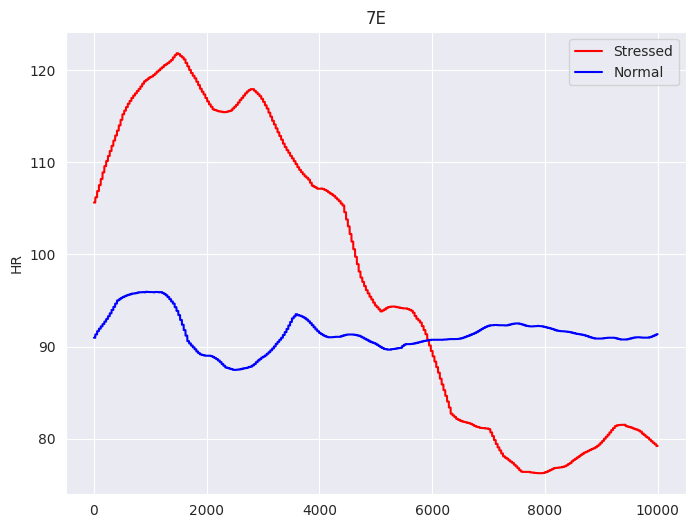

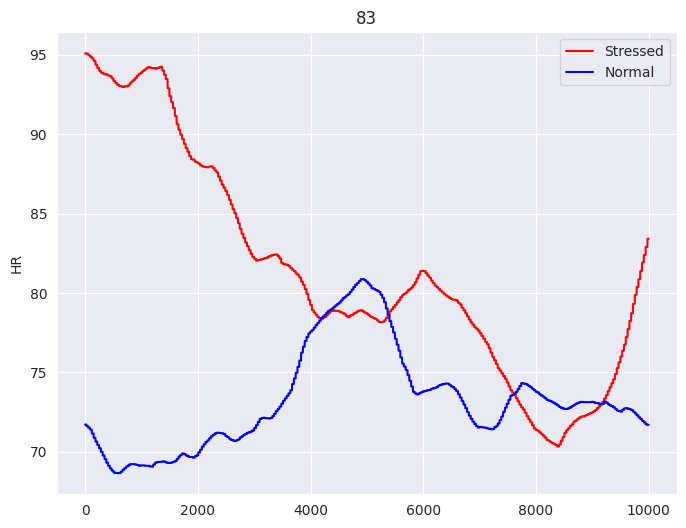

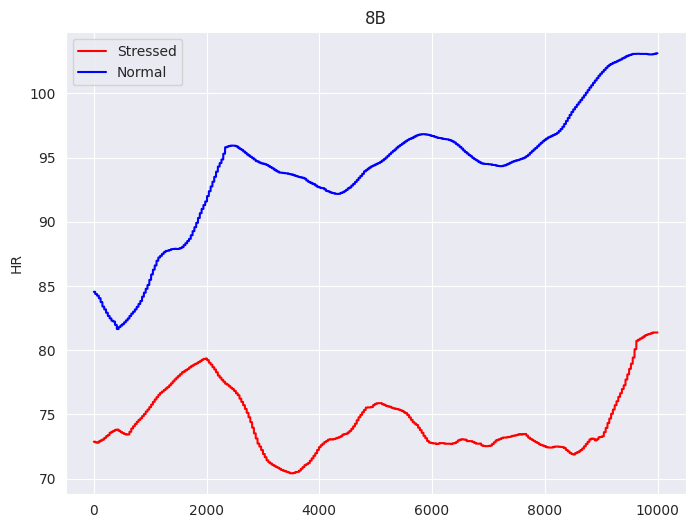

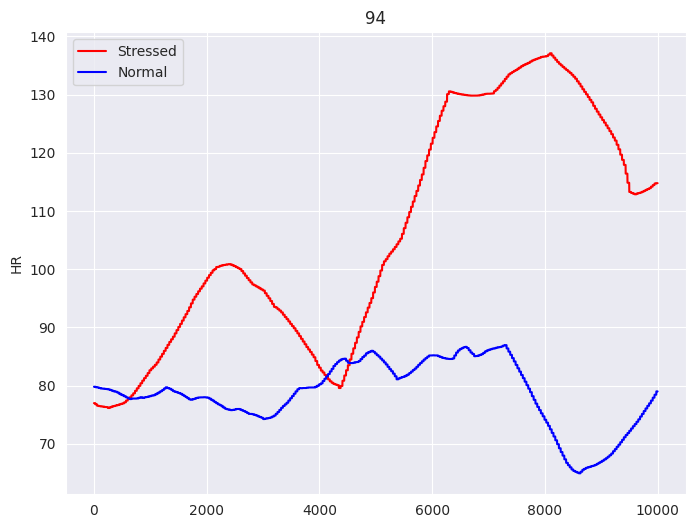

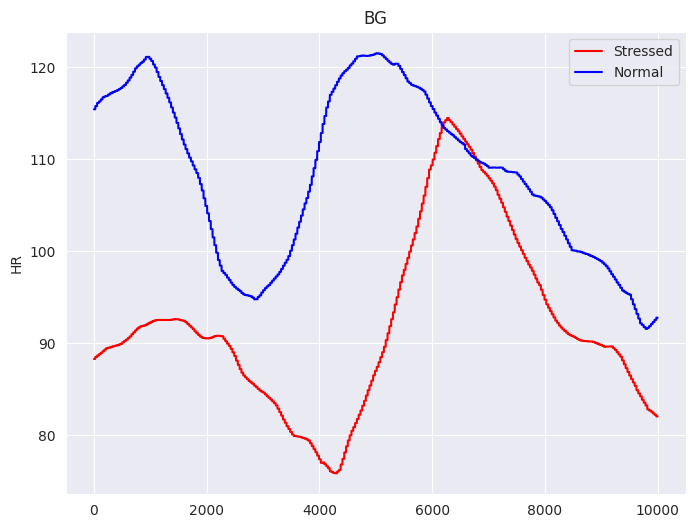

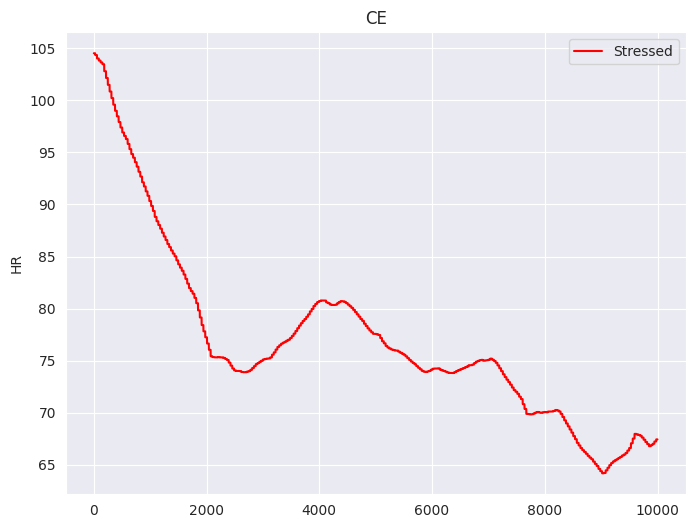

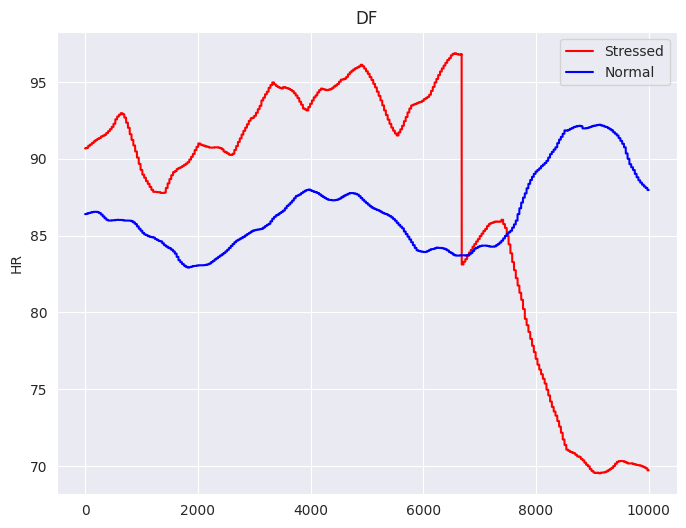

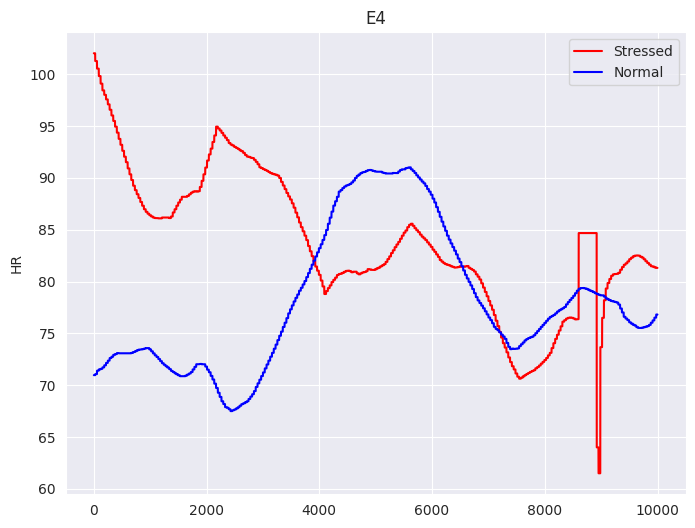

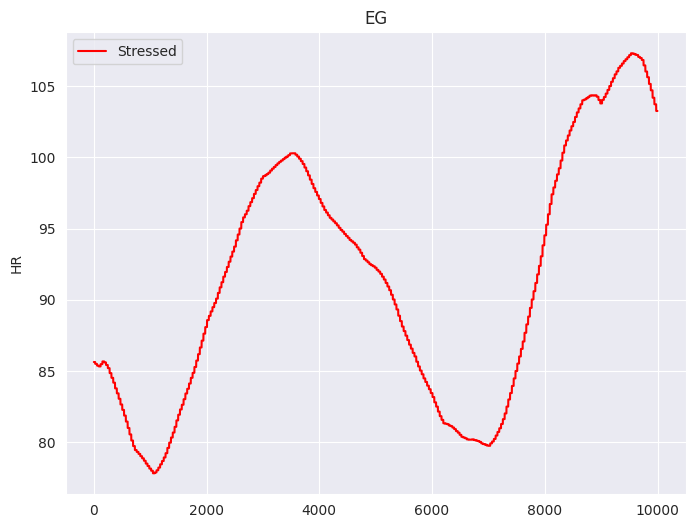

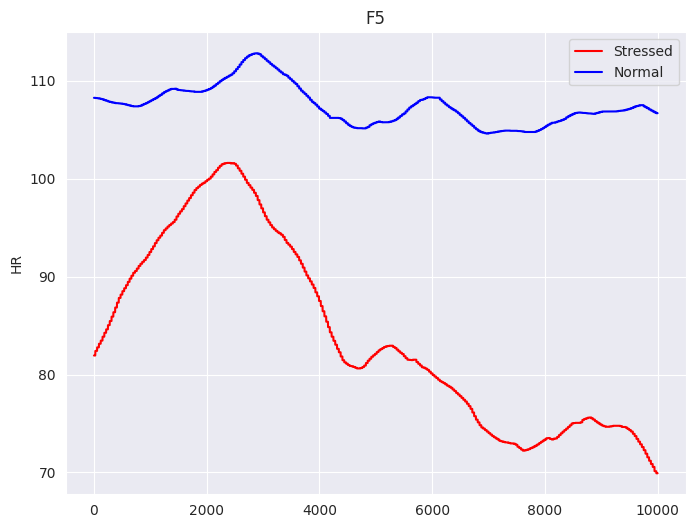

In [ ]:
# creating datasets based on levels of stress
Stress1data = data2[data2['label'] == '1']
Stress0data = data2[data2['label'] == '0']


# HR comparison for each participants
for i in participant_list:
  plt.figure(figsize=(8,6))
  sns.lineplot(data = Stress1data[Stress1data['id'] == i].iloc[1000:11000], x = range(10000), y = 'HR', color = 'red', label ='Stressed')
  if '0' in data2[data2['id'] == i]['label'].unique():
    sns.lineplot(data = Stress0data[Stress0data['id'] == i].iloc[1000:11000], x = range(10000), y = 'HR', color = 'blue', label = 'Normal')
  plt.title(i)

#### From the above graphs, we can observe mixed responses from the participants. For some of the nurses, HR is usually higher when he/she is stressed but other participants experienced the opposite scenario sometimes. 

<Axes: xlabel='id', ylabel='HR'>

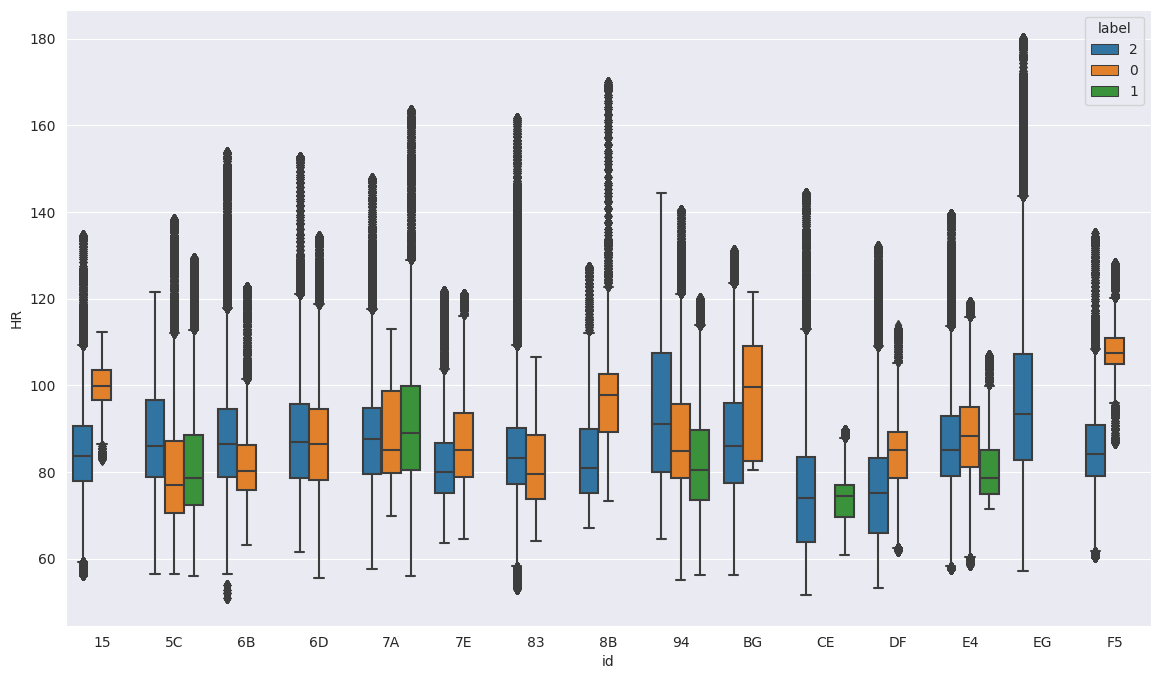

In [ ]:
plt.figure(figsize=(14,8))
sns.boxplot(y = data['HR'], x = data['id'],hue = data['label'])

#### In the above boxplot, we are considering all 15 subjects and the variation of their corresponding Heart rate depending on the stress levels. For '15' and 'F5' participants, experienced higher heart rates under normal conditions rather than in stressed conditions. On the other hand, participants '5C', '6B', and a few others experienced high HR while working under a high level of stress. Exceptionally, participants like 'CE' and 'EG' remained stressed throughout their duration of work

### Temp comparison

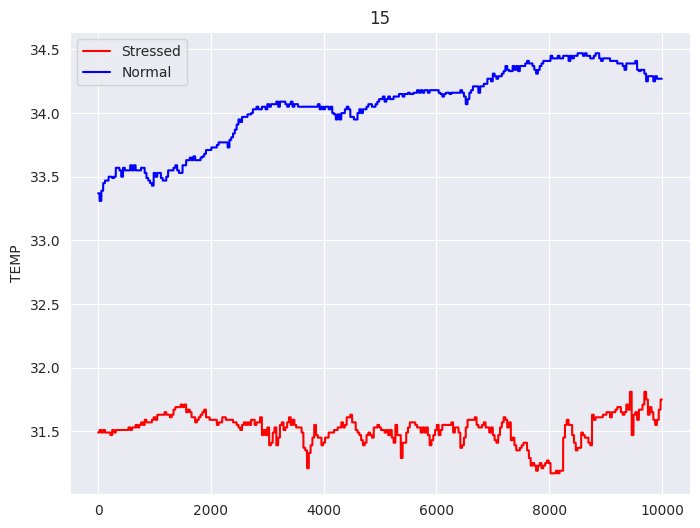

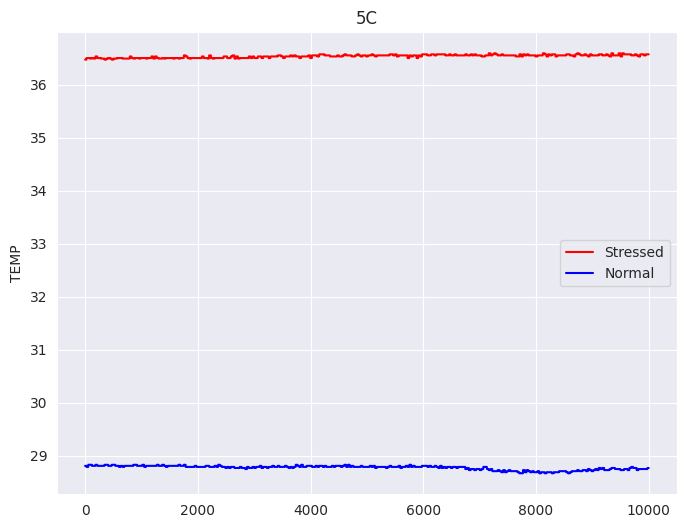

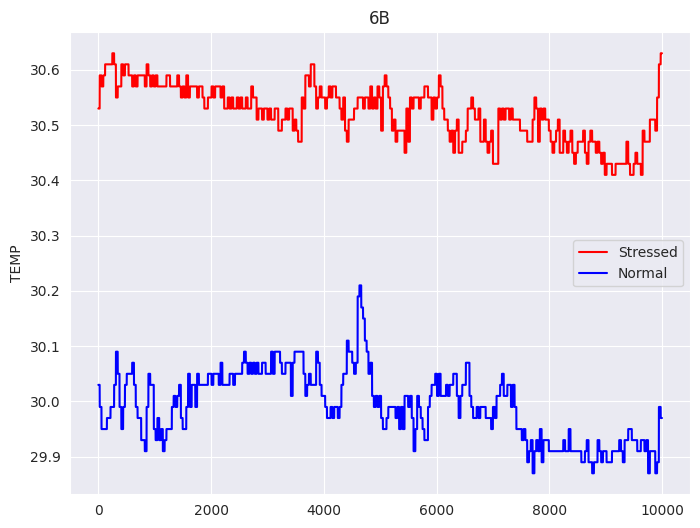

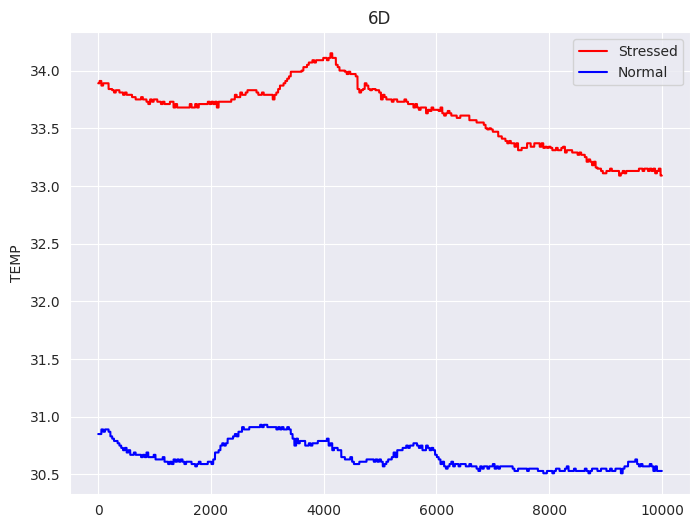

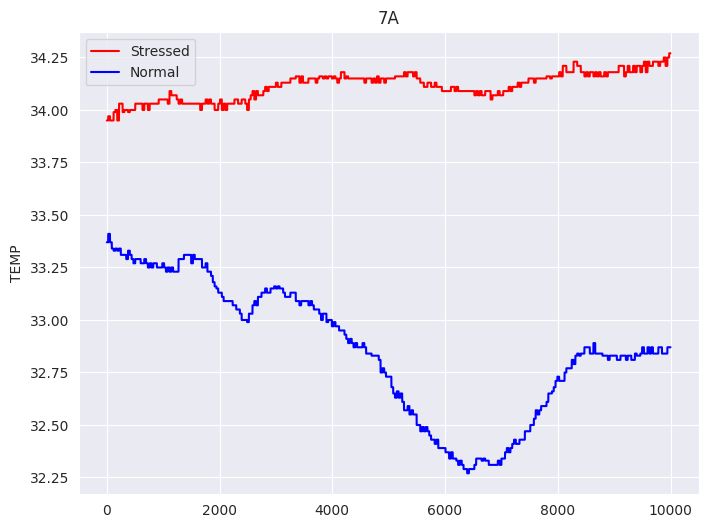

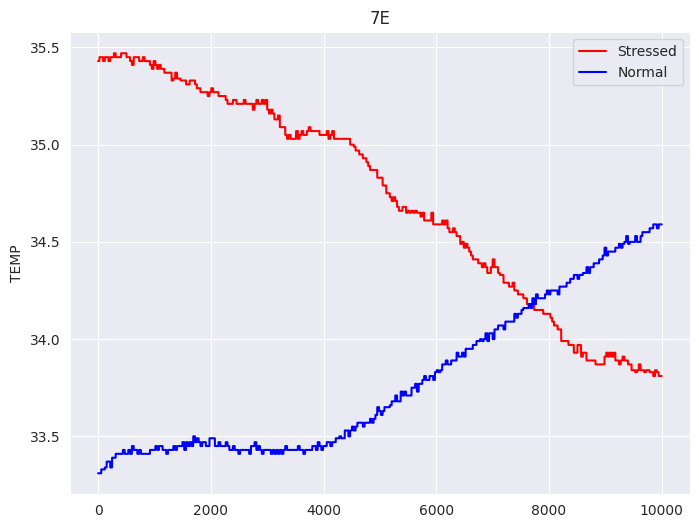

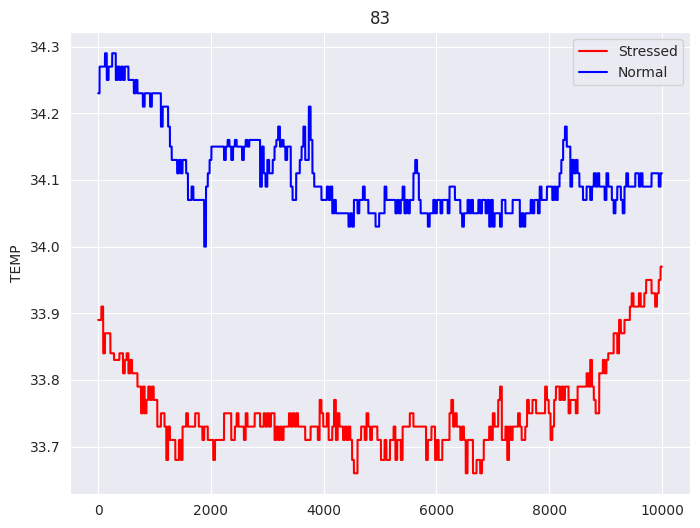

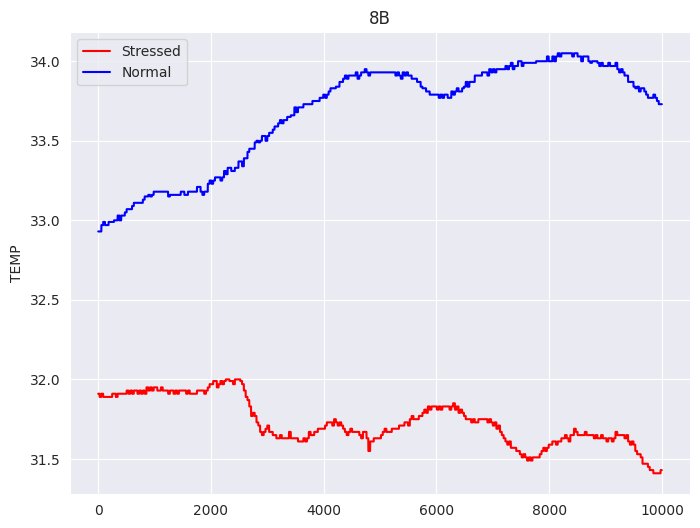

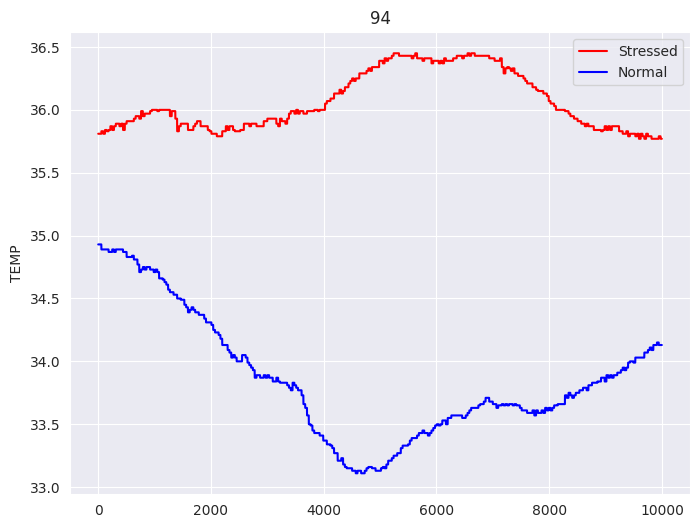

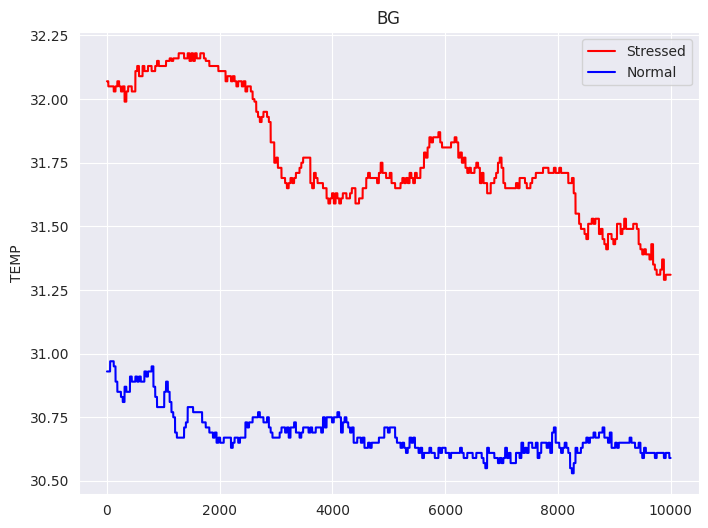

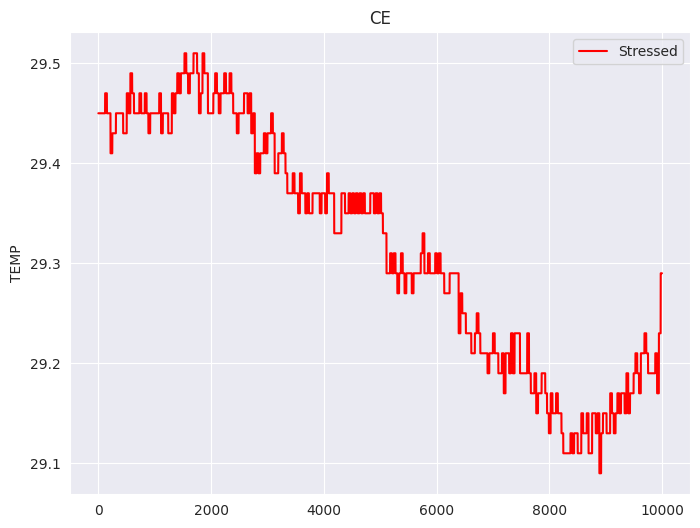

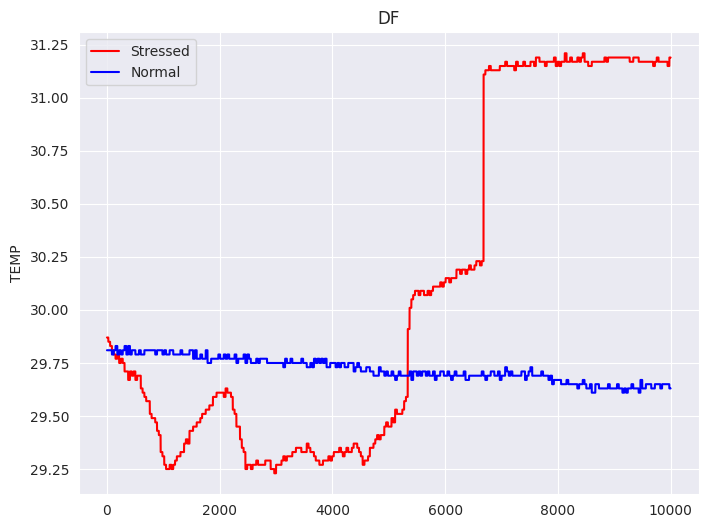

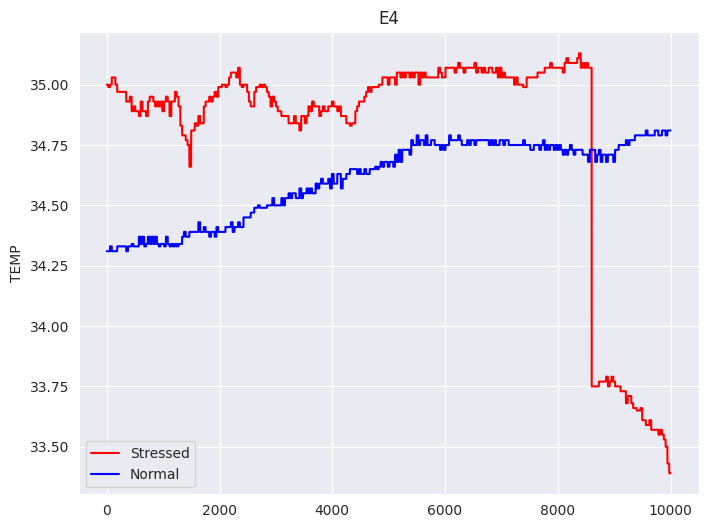

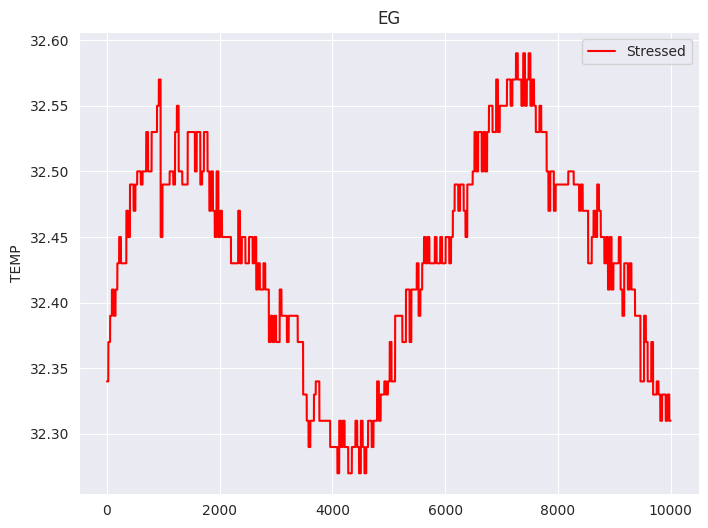

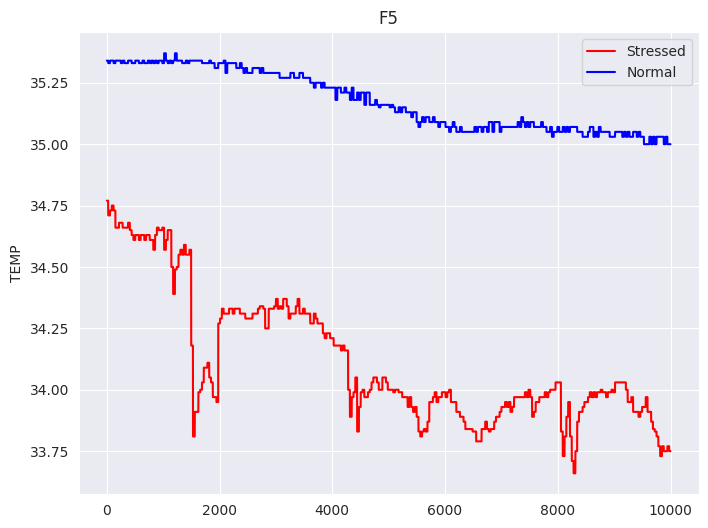

In [ ]:
# Comparing skin temperature for each of the participants

for i in participant_list:
  plt.figure(figsize=(8,6))
  sns.lineplot(data = Stress1data[Stress1data['id'] == i].iloc[1000:11000], x = range(10000), y = 'TEMP', color = 'red', label ='Stressed')
  if '0' in data2[data2['id'] == i]['label'].unique():
    sns.lineplot(data = Stress0data[Stress0data['id'] == i].iloc[1000:11000], x = range(10000), y = 'TEMP', color = 'blue', label = 'Normal')
  plt.title(i)

#### A mixed Response can be observed for Temperature as well. While most of the candidates experienced high skin temperature during stress periods but few participants exhibit lower skin temperature while working under stress periods.

#### Temp comparison among nurses

<Axes: xlabel='id', ylabel='TEMP'>

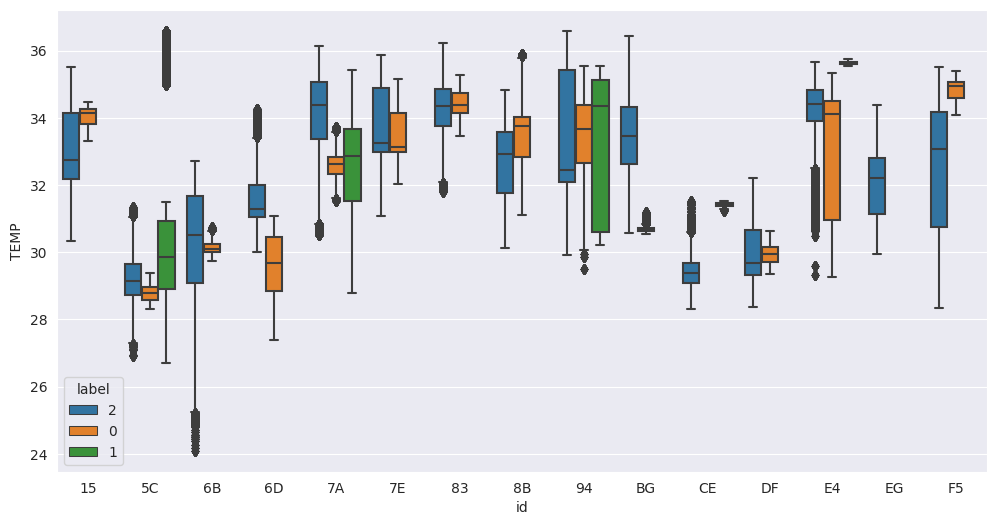

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
sns.boxplot(y = data['TEMP'], x = data['id'],hue = data['label'])

#### Although distortion of the above observation can be seen for some participants. '7A' usually experienced high temperatures during high stress followed by medium and low-level stresses. Whereas, 15 and F5 suffered from high temperatures while they are in normal condition. In the case of 5C, he/she experienced higher temperature during mid-level stress.

### EDA compare

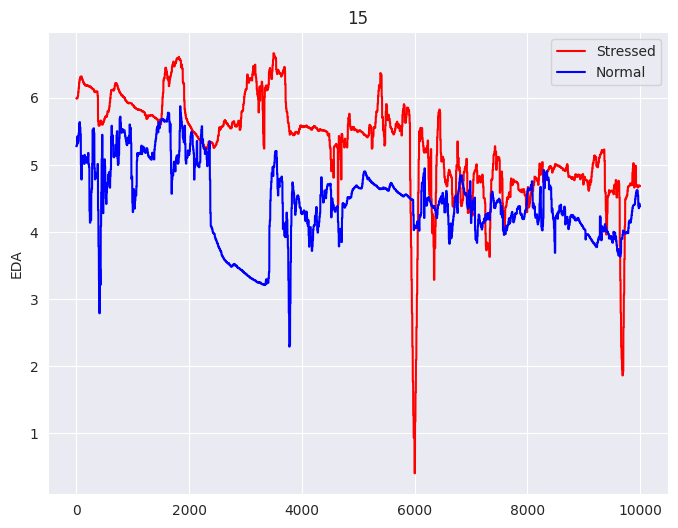

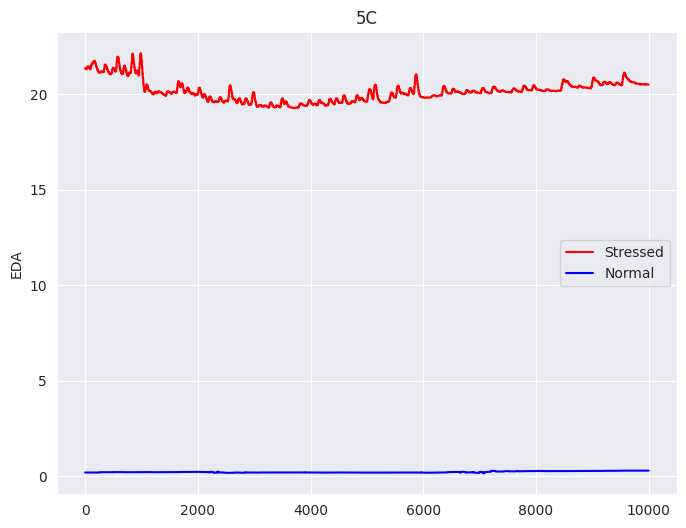

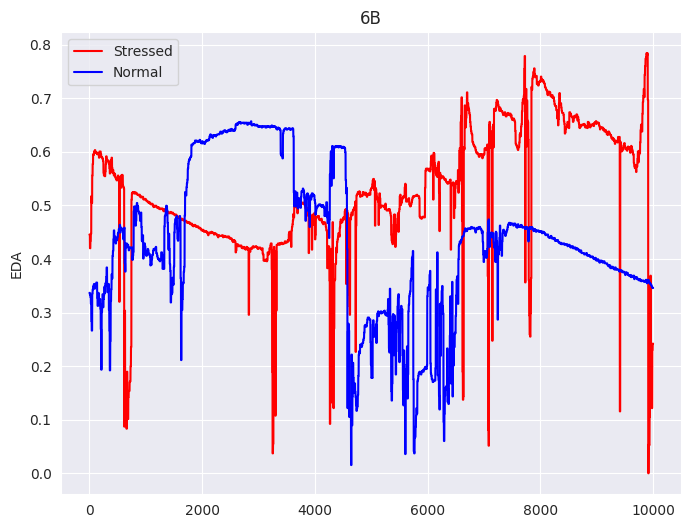

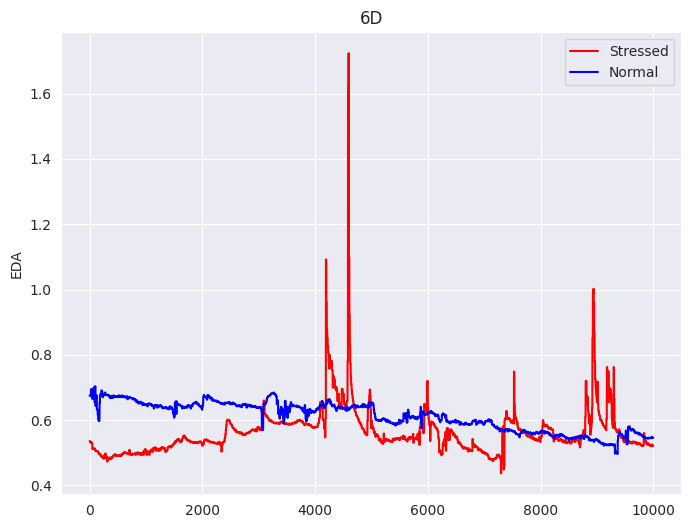

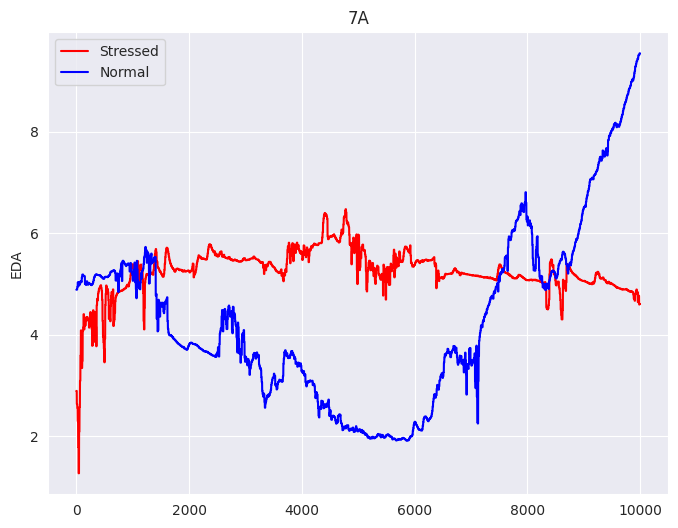

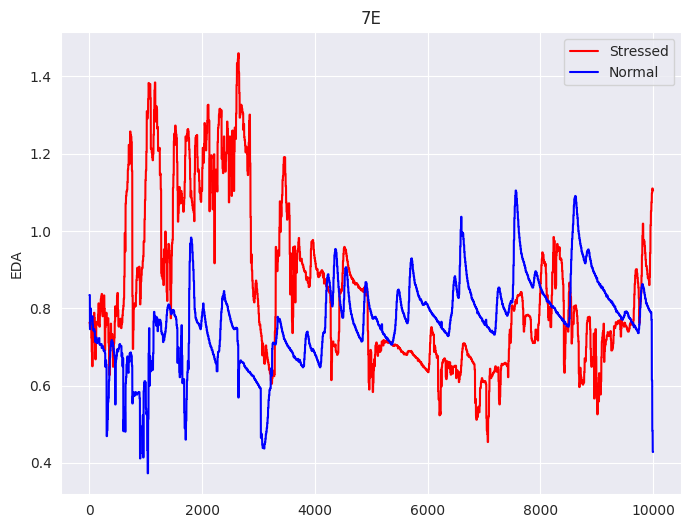

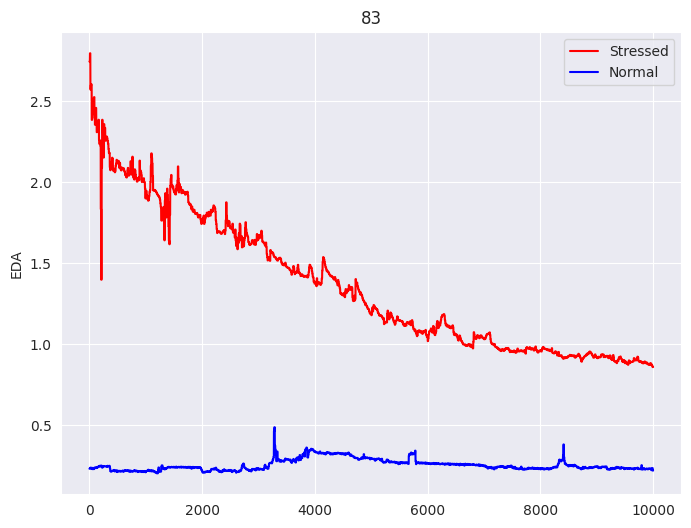

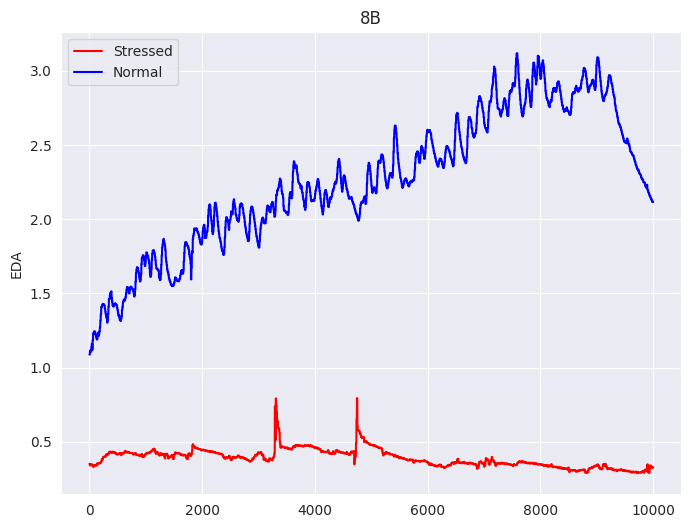

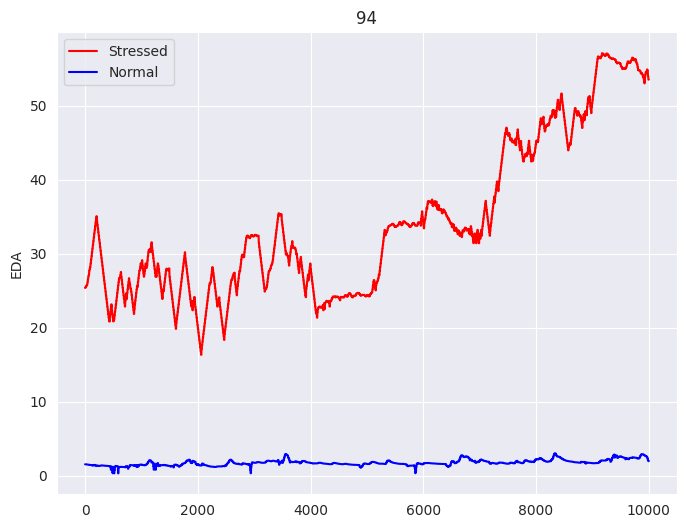

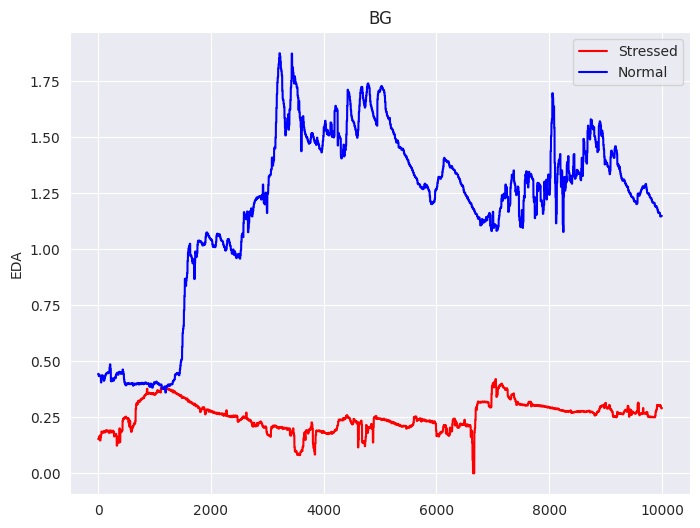

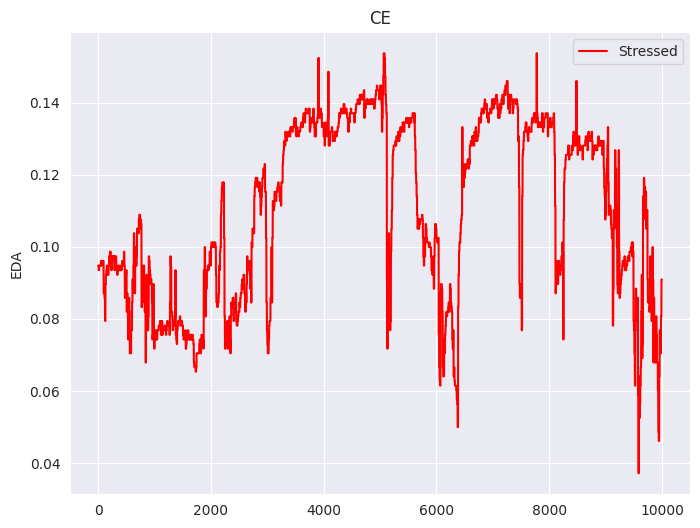

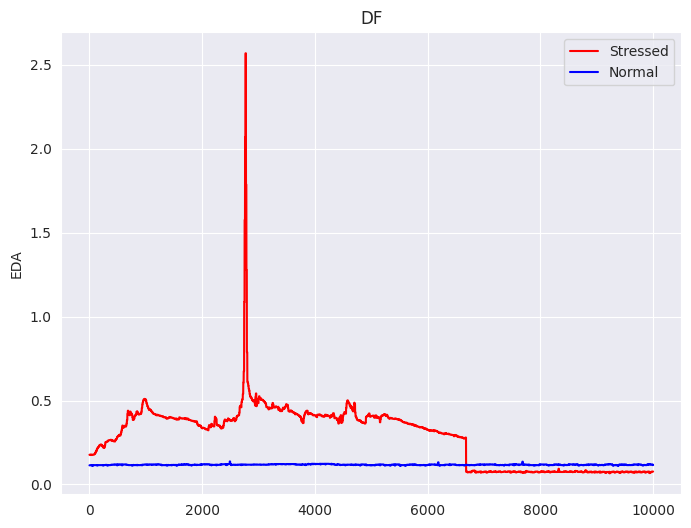

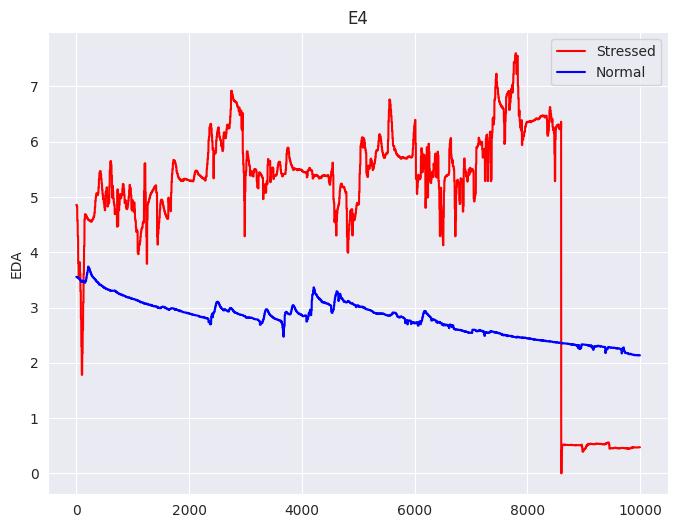

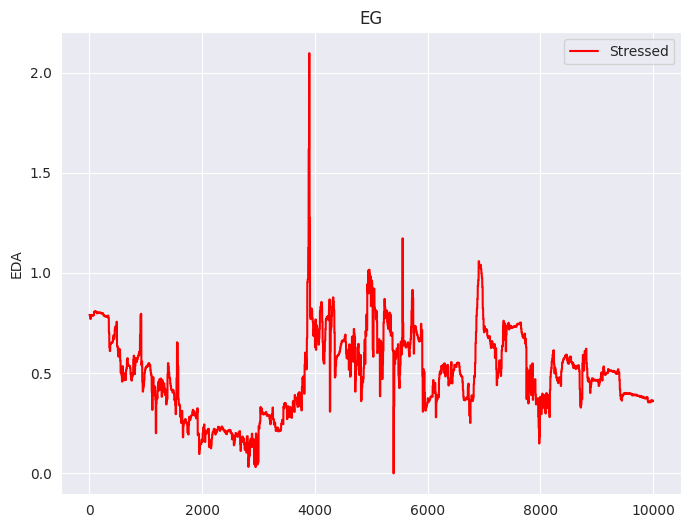

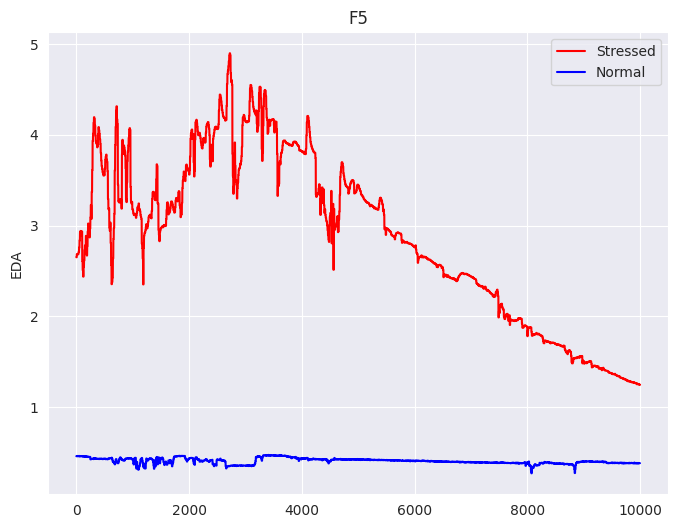

In [ ]:
# Comparing EDA for each of the participants
for i in participant_list:
  plt.figure(figsize=(8,6))
  sns.lineplot(data = Stress1data[Stress1data['id'] == i].iloc[1000:11000], x = range(10000), y = 'EDA', color = 'red', label ='Stressed')
  if '0' in data2[data2['id'] == i]['label'].unique():
    sns.lineplot(data = Stress0data[Stress0data['id'] == i].iloc[1000:11000], x = range(10000), y = 'EDA', color = 'blue', label = 'Normal')
  plt.title(i)

#### From the above graphs, we can say that the electrodermal activity sensor's response often stays at a much higher level during stressed periods than at the normal level. But there are few Candidates whose EDA response is lower while working under stress.

#### EDA comparison among nurses

<Axes: xlabel='id', ylabel='EDA'>

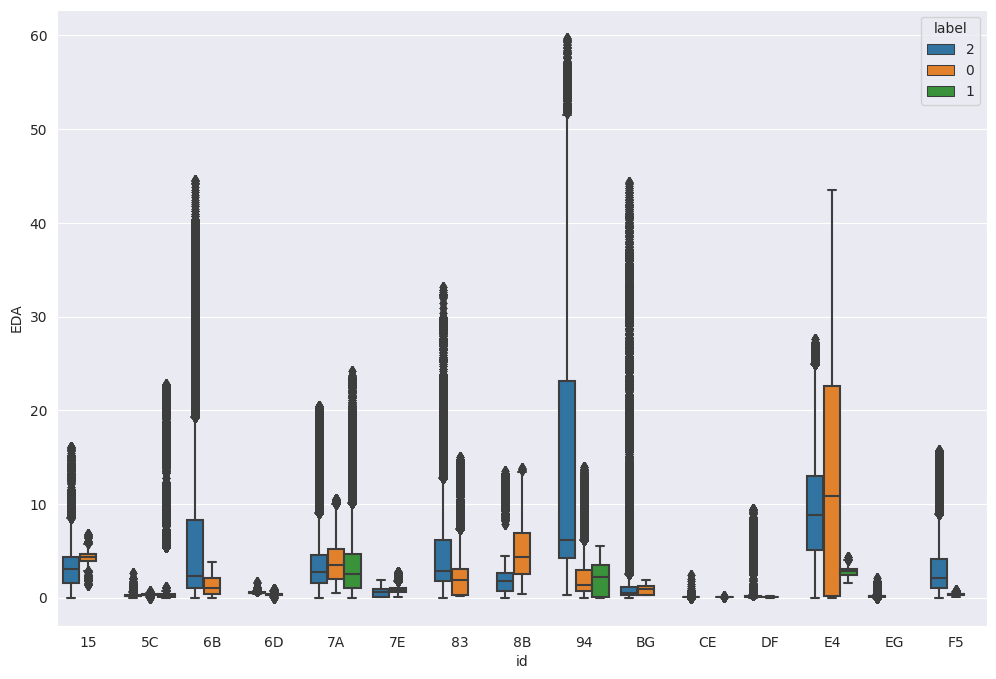

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.boxplot(y = data['EDA'], x = data['id'],hue = data['label'])

#### For 6B, 83, 94, and some others the values for EDA in the stressed situation are greater than that of a normal environment, but we can observe the opposite scenario in the case of E4, 8B, and few more nurses.

### Accelerometer data

<Axes: ylabel='Density'>

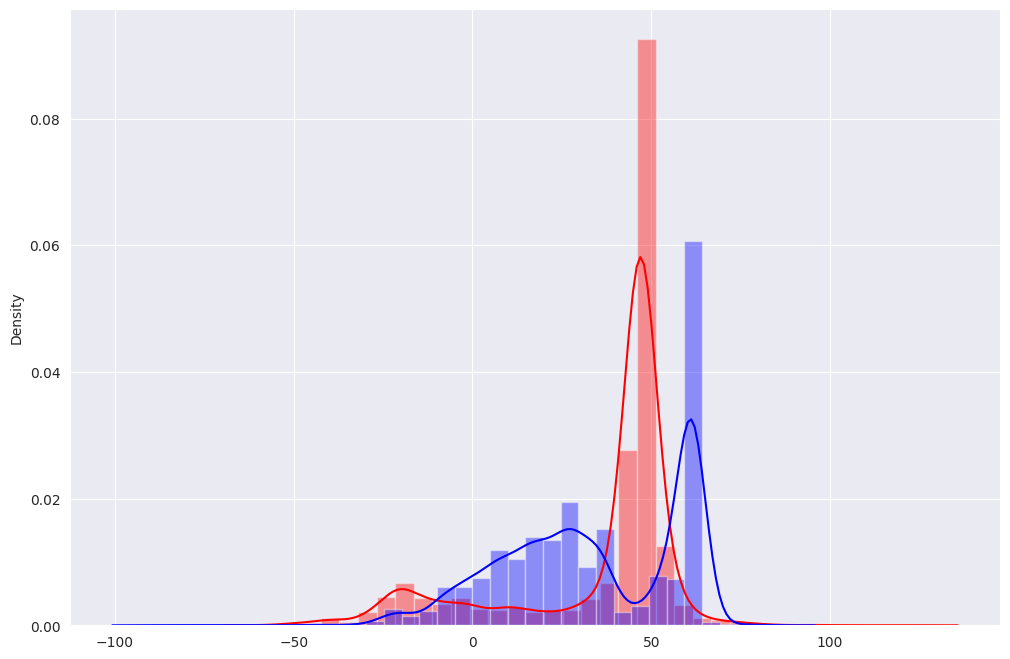

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12,8))
# plotting the univariate distribution of Z-axis data

sns.distplot(x = Stress1data['Z'][100000:110000], color = 'red', bins = 35)
sns.distplot(x = Stress0data['Z'][100000:110000], color = 'blue', bins = 35)


#### From the above graph, we can say that when the z-axis value stays around 50, the subjects usually feel more stressed (high level) and when the z-axis value concentrates around either 25 or 60, the subjects become low stressed

<Axes: ylabel='Density'>

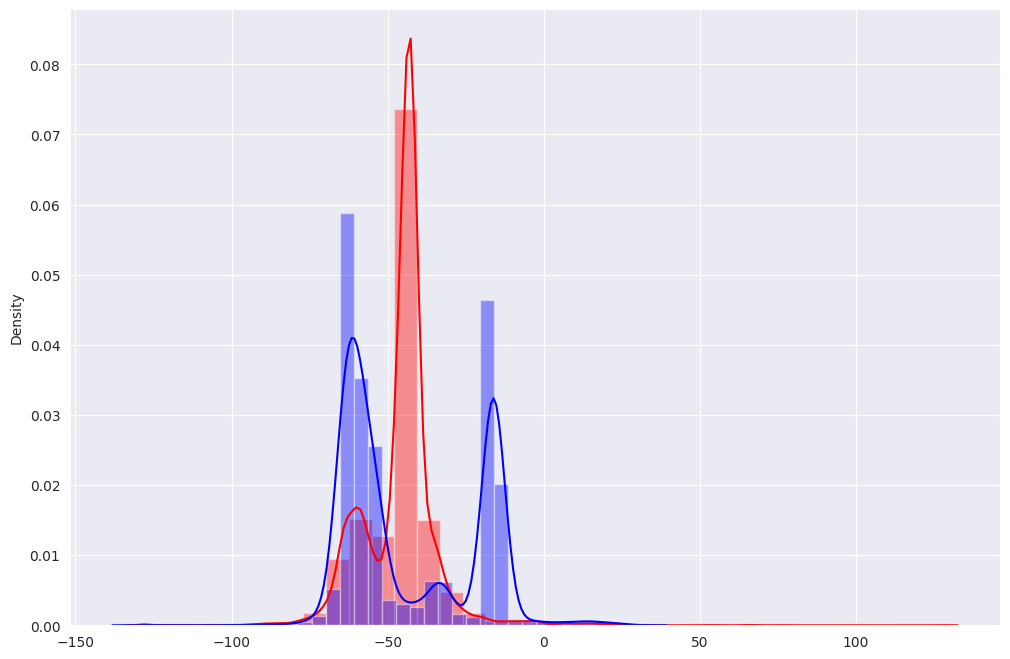

In [ ]:
# plotting the univariate distribution of X-axis data

plt.figure(figsize=(12,8))
sns.distplot(x = Stress1data['X'][100000:110000], color = 'red', bins = 35)
sns.distplot(x = Stress0data['X'][100000:110000], color = 'blue', bins = 35)

#### From the above graph, we can say that when the x-axis value stays around -50, the subjects usually feel more stressed (high level) and when the x-axis value concentrates around either -60 or -25, the subjects become normally stressed.

In [ ]:
# randomizing samples

dataPair = data.sample(n = 70000, replace = False)

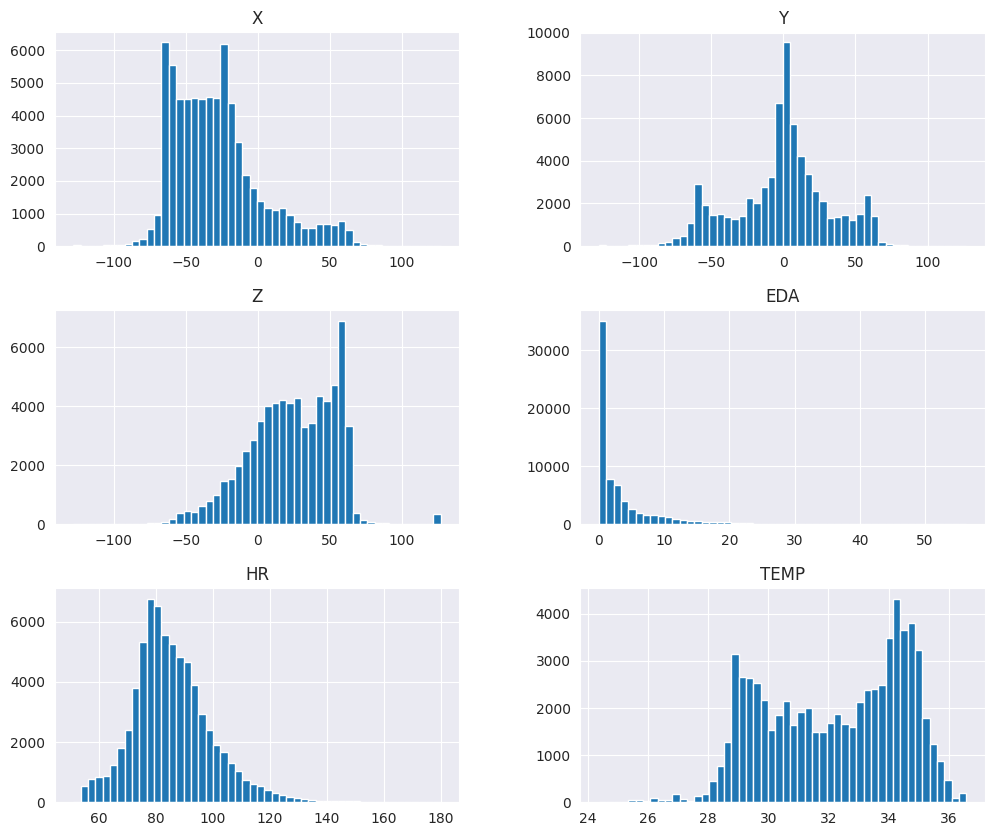

In [ ]:
distribution = dataPair.hist(bins=50, figsize = (12,10))

#### From this graph, we can say that HR is normally distributed but slightly right-skewed and TEMP is showing left-skewed and bi-modal distribution with dual peaks. Again X is showing right skewed distribution and Z is exhibiting left-skewed distribution.

In [ ]:
## plotting the pairplot among the features

sns.pairplot(dataPair, hue = 'label')

Output hidden; open in https://colab.research.google.com to view.

#### From the pair plot, we can fairly say that the EDA, TEMP, and HR signals show higher density distribution under high stressed period followed by low and medium-stressed situations. From the scatterplots( shown inside pairplots), we can observe that no two features are highly co-related to each other as the scatter plots are highly scattered

<Axes: >

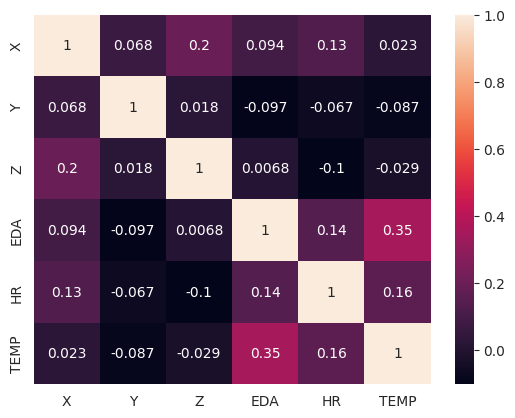

In [ ]:
# plotting heatmap for the correlation matrix among the features

sns.heatmap(data.corr(), annot=True)

#### From the heatmap we can confidently conclude that none of the features are highly corelated with each other. The highest corelation coefficient is 0.35 which is between EDA and TEMP

## Feature selection using Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


## declaring object for Random Forest and One hot Encoder
rfc = RandomForestClassifier(n_estimators=400, random_state=101, criterion='gini', max_depth=6)
ohe = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# converting datetimestamp to UNIX format
data3 = data.copy()
data3 = data3.drop(['datetime'], axis =1)
oneHotEncodedData = pd.get_dummies(data3, columns = ['id'])

In [ ]:
oneHotEncodedData

,X,Y,Z,EDA,HR,TEMP,label,id_15,id_5C,id_6B,...,id_7E,id_83,id_8B,id_94,id_BG,id_CE,id_DF,id_E4,id_EG,id_F5
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307442,-16.0,-56.0,24.0,3.386070,88.37,33.77,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11307443,-8.0,-50.0,27.0,3.386070,88.37,33.77,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11307444,-28.0,-36.0,28.0,3.386070,88.37,33.77,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11307445,-29.0,-29.0,30.0,3.386070,88.37,33.77,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# creating Target variable

Y = oneHotEncodedData.loc[:,'label']

In [ ]:
# creating predictors dataset

X =  oneHotEncodedData.drop('label', axis=1)

In [ ]:
# spliting dataset into training and test

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
# fitting the Random forest classifier model on the training dataset

rfc.fit(X_train, Y_train)

KeyboardInterrupt: ignored

In [ ]:
# generating the feature scores based on the importances of the predictor variables

feature_scores =  pd.Series(rfc.feature_importances_, index = X_train.columns).sort_values(ascending  = False)

In [ ]:
feature_scores

In [ ]:
# plotting bargraph of feature scores based on feature importances

plt.barh([str(x) for x in X_train.columns],rfc.feature_importances_)

#### From the above graph we can say that 'datetime', 'TEMP', 'EDA', 'Z-axis', and 'HR' are the most important features while predicting stress level of a subject. Although one particular subject i.e. '5C' got a descent score but we need to recheck that factor as we did not consider all the participants all at once.

## In the next section, it is discussed how we can process the contributing factors or signals for each participant individually

## Code to merge signals for each Individual

In [ ]:
parent = 'Z:\ESSEX_Study\Decision Making\Assignment\Experimental_Data'
subject_folders_paths = [name for name in os.listdir(parent)]
for subject_path in subject_folders_paths:
    deep_folders = [name for name in os.listdir(parent+'\\'+subject_path)]
    signals = ['EDA','HR','BVP','TEMP']
    for signal in signals:
        print(signal)
        if signal == 'EDA' or signal == 'TEMP':
            sample_rate = 4*10
        elif signal == 'BVP':
            sample_rate = 64*10
        elif signal == 'HR':
            sample_rate = 1*10
        dataframe = pd.DataFrame(columns = ['Timestamp',signal])
        dataframe.loc['0'] = [0,0]
        count = 1
        for j in deep_folders:
            data = pd.read_csv(parent+'\\'+subject_path +"\\"+ j+'\\'+signal+'.csv', header = None)
            time = data[0][0] + 1
            data = data.iloc[2:,:].reset_index(drop = True)
            for i in range(0,len(data),sample_rate):
                avg = round(float(data.iloc[i:i+sample_rate,:].mean()),3)
                dataframe.loc[str(count)] = [time,avg]
                time = time + 1
                count = count + 1            
        dataframe.to_csv(parent+'\\'+subject_path+'\\combined'+signal+'.csv')
        print('Dataframe for '+signal+' created')
    BVP_df = pd.read_csv(parent+'\\'+subject_path+'\\'+'combinedBVP.csv').iloc[:,1:]
    HR_df = pd.read_csv(parent+'\\'+subject_path+'\\'+'combinedHR.csv').iloc[:,1:]
    TEMP_df = pd.read_csv(parent+'\\'+subject_path+'\\'+'combinedTEMP.csv').iloc[:,1:]
    EDA_df = pd.read_csv(parent+'\\'+subject_path+'\\'+'combinedEDA.csv').iloc[:,1:]
    min_length = min(len(BVP_df),len(HR_df),len(TEMP_df),len(EDA_df) )
    
    merged_df_BVP_HR = pd.merge(BVP_df.iloc[0:min_length], HR_df.iloc[0:min_length], on = 'Timestamp', how = 'inner')
    merged_df_TEMP = pd.merge(merged_df_BVP_HR, TEMP_df.iloc[0:min_length], on = 'Timestamp', how = 'inner')
    merged_df_Final = pd.merge(merged_df_TEMP, EDA_df.iloc[0:min_length], on = 'Timestamp', how = 'inner')
    
    merged_df_Final.to_csv(parent+'\\'+subject_path+'\\'+'MergedData.csv')

EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Dataframe for HR created
BVP
Dataframe for BVP created
TEMP
Dataframe for TEMP created
EDA
Dataframe for EDA created
HR
Datafra

#### Here we are not considering IBI signal which is extracted from the BVP signal and inversely proportional to the stress level

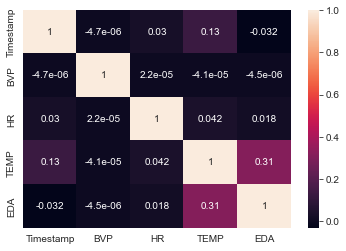

In [ ]:
sns.heatmap(merged_df_Final.corr(), annot = True)

#### From the below we can say that none of the features are highly co-related to each other

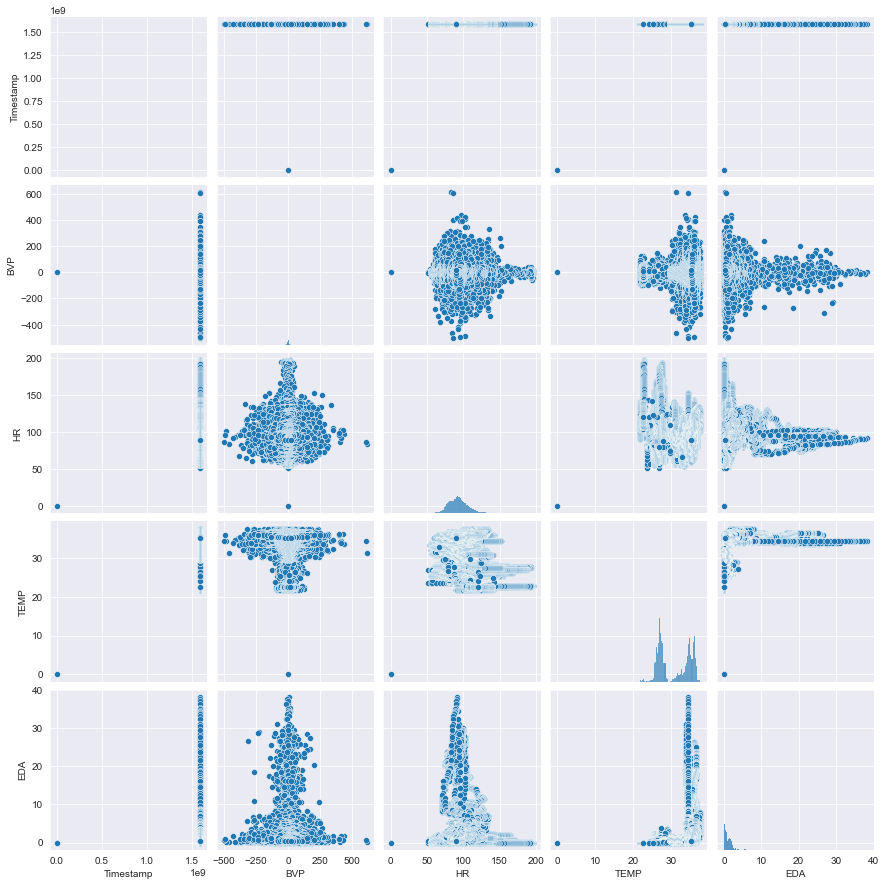

In [ ]:
sns.pairplot(merged_df_Final)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA93E42C70>,
      dtype=object)

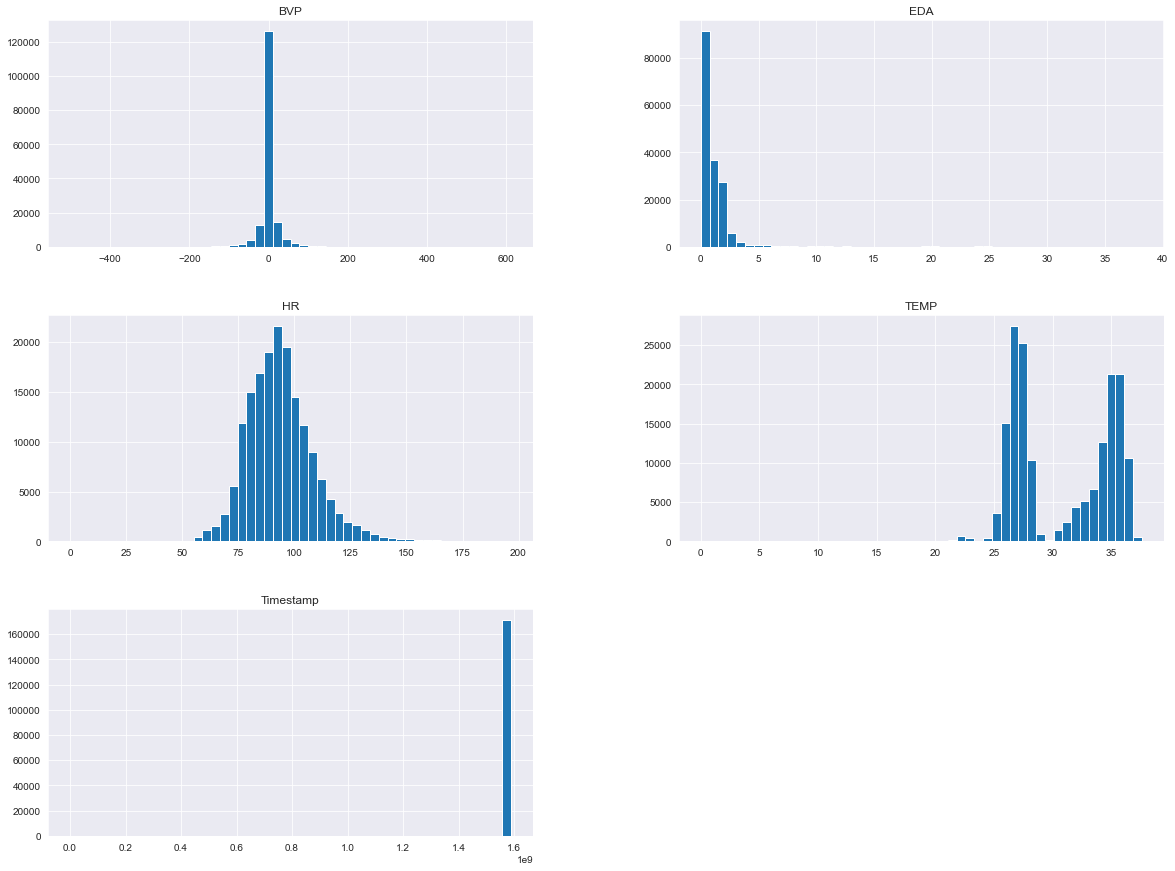

In [ ]:
merged_df_Final.hist(bins=50, figsize = (20,15) )

#### For the participant under test, we can say that HR is normally distributed and EDA is exhibiting highly right skewed distribution. BVP has strongly leptokurtic distribution and TEMP is showing bi-modal distribution

# ***Data Preprocessing For Models***

### Read and Analyse Dataset

In [3]:
# Reading the final dataset

combined = pd.read_csv('/content/drive/MyDrive/DSDM_Temp/merged_data_labeled.csv')

<ipython-input-3-376ce2dfac8d>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  combined = pd.read_csv('/content/drive/MyDrive/DSDM_Temp/merged_data_labeled.csv')


In [4]:
combined

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11307442,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11307443,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11307444,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11307445,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [5]:
combined['label'].unique()

array([2., 0., 1.])

In [6]:
combined['id'] = combined['id'].replace(15,'15')

<Axes: xlabel='label', ylabel='count'>

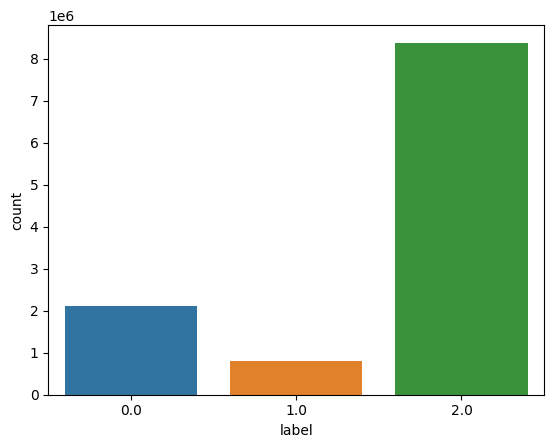

In [7]:
# Checking the number of counts for each type of stress level
import seaborn as sns
sns.countplot(x ='label', data = combined)

In [8]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11307447 entries, 0 to 11307446
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   EDA       float64
 4   HR        float64
 5   TEMP      float64
 6   id        object 
 7   datetime  object 
 8   label     float64
dtypes: float64(7), object(2)
memory usage: 776.4+ MB


In [9]:
# Merging both Stress levels
combined['label'] = combined['label'].replace({2.0:1.0})

In [10]:
combined['label'].value_counts()

1.0    9191282
0.0    2116165
Name: label, dtype: int64

In [11]:
combined

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,1.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,1.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,1.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,1.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,1.0
...,...,...,...,...,...,...,...,...,...
11307442,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,1.0
11307443,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,1.0
11307444,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,1.0
11307445,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,1.0


### Analysis for each participant

In [102]:
# Extracting data for '5C' participant

combined1 = combined.copy()
data_5C = combined1[combined1['id'] == '5C']

In [103]:
# sorting the dataset based on datatime in ascending order
data_5C = data_5C.sort_values('datetime')
data_5C['label'].value_counts()

1.0    556809
0.0    309121
Name: label, dtype: int64

In [104]:
data_5C.head(2)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
309131,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.000000000,1.0
309132,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.031249920,1.0


In [105]:
# coverting the 'datatime' column to datatime object
data_5C['datetime'] = pd.to_datetime(data_5C['datetime'])

In [106]:
# setting datatime column as index column
data_5C.set_index('datetime', inplace=True)

In [107]:
# dropping the ID column
data_5C.drop(['id'], axis=1, inplace=True)

### TrainTest Split

In [19]:
column_train = list(data_5C.columns[[data_5C.columns != 'label']])
column_train

['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']

In [40]:
len(data_5C)

865930

In [41]:
# X = data_5C.iloc[:,:-1]
# y = data_5C['label']
train_df, test_df = data_5C.iloc[:int(len(data_5C)*0.7), :], data_5C.iloc[int(len(data_5C)*0.7):, :]

In [42]:
train_df['label'].value_counts()

0.0    309121
1.0    297030
Name: label, dtype: int64

In [43]:
test_df['label'].value_counts()

1.0    259779
Name: label, dtype: int64

## Dataframe Processing - Creation of Statisctical and Frequency domain features

In [108]:
X_list = []
Y_list = []
Z_list = []
EDA_list = []
HR_list = []
TEMP_list = []
label_list = []

window_size = 160     # 5 seconds
step_size = 32        # each second continues for 32 samples

# creating overlaping windows of size window-size 100
for i in range(0, data_5C.shape[0] - window_size, step_size):
    x = data_5C['X'].values[i: i + window_size]
    y = data_5C['Y'].values[i: i + window_size]
    z = data_5C['Z'].values[i: i + window_size]
    eda = data_5C['EDA'].values[i: i + window_size]
    hr = data_5C['HR'].values[i: i + window_size]
    temp = data_5C['TEMP'].values[i: i + window_size]
    label = stats.mode(data_5C['label'][i: i + window_size])[0][0]

    X_list.append(x)
    Y_list.append(y)
    Z_list.append(z)
    EDA_list.append(eda)
    HR_list.append(hr)
    TEMP_list.append(temp)
    label_list.append(label)

In [109]:
len(X_list)

27056

In [110]:
data5C = pd.DataFrame()

# mean
data5C['x_mean'] = pd.Series(X_list).apply(lambda x: x.mean())
data5C['y_mean'] = pd.Series(Y_list).apply(lambda x: x.mean())
data5C['z_mean'] = pd.Series(Z_list).apply(lambda x: x.mean())
data5C['eda_mean'] = pd.Series(EDA_list).apply(lambda x: x.mean())
data5C['hr_mean'] = pd.Series(HR_list).apply(lambda x: x.mean())
data5C['temp_mean'] = pd.Series(TEMP_list).apply(lambda x: x.mean())

# std dev
data5C['eda_std'] = pd.Series(EDA_list).apply(lambda x: x.std())
data5C['hr_std'] = pd.Series(HR_list).apply(lambda x: x.std())
data5C['temp_std'] = pd.Series(TEMP_list).apply(lambda x: x.std())

# min
data5C['eda_min'] = pd.Series(EDA_list).apply(lambda x: x.min())
data5C['hr_min'] = pd.Series(HR_list).apply(lambda x: x.std())
data5C['temp_min'] = pd.Series(TEMP_list).apply(lambda x: x.std())

# max
data5C['eda_max'] = pd.Series(EDA_list).apply(lambda x: x.max())
data5C['hr_max'] = pd.Series(HR_list).apply(lambda x: x.max())
data5C['temp_max'] = pd.Series(TEMP_list).apply(lambda x: x.max())

# energy
data5C['eda_energy'] = pd.Series(EDA_list).apply(lambda x: np.sum(x**2)/32)
data5C['hr_energy'] = pd.Series(HR_list).apply(lambda x: np.sum(x**2)/32)
data5C['temp_energy'] = pd.Series(TEMP_list).apply(lambda x: np.sum(x**2/32))

# RMS

data5C['eda_rms'] = pd.Series(EDA_list).apply(lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x)))))
data5C['hr_rms'] = pd.Series(HR_list).apply(lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x)))))
data5C['temp_rms'] = pd.Series(TEMP_list).apply(lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x)))))

In [111]:
X_list_fft = pd.Series(X_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
Y_list_fft = pd.Series(Y_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
Z_list_fft = pd.Series(Z_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
EDA_list_fft = pd.Series(EDA_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
HR_list_fft = pd.Series(HR_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
TEMP_list_fft = pd.Series(TEMP_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])


# Statistical Features on raw x, y and z in frequency domain
# FFT mean
data5C['X_mean_fft'] = pd.Series(X_list_fft).apply(lambda x: x.mean())
data5C['Y_mean_fft'] = pd.Series(Y_list_fft).apply(lambda x: x.mean())
data5C['Z_mean_fft'] = pd.Series(Z_list_fft).apply(lambda x: x.mean())
data5C['EDA_mean_fft'] = pd.Series(EDA_list_fft).apply(lambda x: x.mean())
data5C['HR_mean_fft'] = pd.Series(HR_list_fft).apply(lambda x: x.mean())
data5C['TEMP_mean_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: x.mean())

# FFT min
data5C['EDA_min_fft'] = pd.Series(EDA_list_fft).apply(lambda x: x.min())
data5C['HR_min_fft'] = pd.Series(HR_list_fft).apply(lambda x: x.min())
data5C['TEMP_min_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: x.min())

# FFT max
data5C['EDA_mean_fft'] = pd.Series(EDA_list_fft).apply(lambda x: x.max())
data5C['HR_max_fft'] = pd.Series(HR_list_fft).apply(lambda x: x.max())
data5C['TEMP_max_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: x.max())

# FFT energy
data5C['EDA_energy_fft'] = pd.Series(EDA_list_fft).apply(lambda x: np.sum(x**2)/32)
data5C['HR_energy_fft'] = pd.Series(HR_list_fft).apply(lambda x: np.sum(x**2)/32)
data5C['TEMP_energy_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: np.sum(x**2/32))


In [112]:
data5C

,x_mean,y_mean,z_mean,eda_mean,hr_mean,temp_mean,eda_std,hr_std,temp_std,eda_min,...,HR_mean_fft,TEMP_mean_fft,EDA_min_fft,HR_min_fft,TEMP_min_fft,HR_max_fft,TEMP_max_fft,EDA_energy_fft,HR_energy_fft,TEMP_energy_fft
0,-21.98125,-43.43750,127.00000,21.975767,82.582000,36.494000,0.031713,0.093680,0.004899,21.912420,...,413.803915,182.519587,9.813078e-18,1.962616e-17,0.000000e+00,13213.12,5839.04,386347.878213,5.455833e+06,1.065450e+06
1,-21.98750,-43.42500,127.00000,22.025087,82.502000,36.502000,0.101617,0.142464,0.014697,21.912420,...,413.945935,182.652851,3.103168e-17,5.721958e-17,5.204170e-18,13200.32,5840.32,388087.620238,5.445272e+06,1.065917e+06
2,-21.98750,-43.44375,127.00000,22.045839,82.404000,36.508000,0.111581,0.160574,0.018330,21.912420,...,413.599413,182.698837,9.813078e-18,2.775558e-17,2.168404e-18,13184.64,5841.28,388820.178036,5.432346e+06,1.066267e+06
3,-21.98750,-43.55000,127.00000,22.038602,82.286000,36.508000,0.115653,0.174654,0.018330,21.912420,...,413.179473,182.698837,1.387779e-17,5.551115e-17,1.040834e-17,13165.76,5841.28,388565.283952,5.416801e+06,1.066267e+06
4,-22.00625,-43.43750,127.00000,22.128795,82.172000,36.508000,0.192138,0.170693,0.018330,21.912420,...,412.574447,182.698837,7.850462e-17,0.000000e+00,5.204170e-18,13147.52,5841.28,391761.296071,5.401802e+06,1.066267e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27051,-33.59375,-44.19375,2.43125,0.196761,89.044812,27.048250,0.028744,0.150570,0.019923,0.140921,...,447.156277,135.423080,2.306000e-02,5.427696e-01,1.098801e-02,14247.17,4327.72,31.295880,6.343192e+06,5.852864e+05
27052,-30.73750,-44.73750,3.45625,0.201805,89.152750,27.043125,0.030448,0.143588,0.017182,0.140921,...,447.508884,135.378888,2.159419e-02,4.440688e-01,2.000000e-02,14264.44,4326.90,32.944777,6.358578e+06,5.850646e+05
27053,-27.99375,-46.40000,2.36250,0.211870,89.262500,27.042000,0.023582,0.177577,0.016000,0.143483,...,448.296442,135.366374,1.549681e-02,4.055699e-01,0.000000e+00,14282.00,4326.72,36.125388,6.374248e+06,5.850159e+05
27054,-23.26875,-50.63750,4.95625,0.220749,89.394625,27.044875,0.012975,0.219399,0.015370,0.166543,...,449.435535,135.359191,3.508593e-02,5.366986e-01,1.715564e-02,14303.14,4327.18,39.045768,6.393138e+06,5.851403e+05


In [113]:
data_5C

,X,Y,Z,EDA,HR,TEMP,label
datetime,,,,,,,
2020-04-14 22:31:00.000000000,-22.0,-43.0,127.0,21.941885,82.67,36.49,1.0
2020-04-14 22:31:00.031249920,-22.0,-43.0,127.0,21.941885,82.67,36.49,1.0
2020-04-14 22:31:00.062500096,-22.0,-43.0,127.0,21.941885,82.67,36.49,1.0
2020-04-14 22:31:00.093750016,-22.0,-43.0,127.0,21.941885,82.67,36.49,1.0
2020-04-14 22:31:00.124999936,-22.0,-43.0,127.0,21.941885,82.67,36.49,1.0
...,...,...,...,...,...,...,...
2020-06-25 17:25:59.875000064,-22.0,-57.0,-11.0,0.217787,90.00,27.07,1.0
2020-06-25 17:25:59.906249984,-23.0,-49.0,-5.0,0.217787,90.00,27.07,1.0
2020-06-25 17:25:59.937499904,-22.0,-48.0,-2.0,0.217787,90.00,27.07,1.0


In [114]:
X = data5C.copy()
y = label_list.copy()
print(X.shape, len(y))

(27056, 35) 27056


# ***Model Implementations***

### ***TimeSeriesSplit***

In [116]:
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

In [115]:
def convertToSequence(predictor, target, window_size=5):
  predictor = predictor.to_numpy()
  X = []
  y = []
  for i in range(len(predictor)-window_size):
    row = [r for r in predictor[i:i+window_size]]
    X.append(row)
    label = target[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [117]:
data5C
training_frac = int(X.shape[0]*0.75)
#test_frac = int(X1.shape[0]*0.25)
train_df = X.iloc[:training_frac,:]
test_df = X.iloc[training_frac:,:]
X5, Y5 = train_df.iloc[:,:-1], y[:training_frac]
X_test5, Y_test5 = test_df.iloc[:,:-1], y[training_frac:]
Y5 = np.array(Y5)
Y_test5 = np.array(Y_test5)

In [118]:
print(X5.shape, X_test5.shape, Y5.shape, Y_test5.shape)

(20292, 34) (6764, 34) (20292,) (6764,)


In [119]:
np.unique(Y_test5)

array([1.])

#### ***LSTM***

In [120]:
# Creating Bidirectional LSTM models.
# Window size is taken as 5 as we are interested in checking the records of previous 5 seconds

dropout = 0.1
window_size = 5

model = keras.Sequential()
model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, X5.shape[-1])))
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM((window_size * 2), return_sequences=True))) 
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(window_size, return_sequences=False))) 
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='mean_squared_error',optimizer='adam')

In [121]:
X_seq, Y_seq = convertToSequence(X5, Y5, 5)
X_seq_test, Y_seq_test = convertToSequence(X_test5, Y_test5)

In [122]:
tcsv = TimeSeriesSplit(n_splits=5)
for tr_index, val_index in tcsv.split(X_seq):
  print(tr_index, val_index)
  X_tr, X_val = X_seq[:tr_index[-1]], X_seq[tr_index[-1]:val_index[-1]]
  Y_tr, Y_val = Y_seq[:tr_index[-1]], Y_seq[tr_index[-1]:val_index[-1]]
  # print(X_tr)
  model.fit(X_tr, Y_tr, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
Epoch 1/10
106/106 [==============================] - 16s 43ms/step - loss: 0.1063 - val_loss: 0.7642
Epoch 2/10
106/106 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.8093
Epoch 3/10
106/106 [==============================] - 2s 22ms/step - loss: 4.0167e-04 - val_loss: 0.8204
Epoch 4/10
106/106 [==============================] - 3s 30ms/step - loss: 2.3071e-04 - val_loss: 0.8260
Epoch 5/10
106/106 [==============================] - 2s 17ms/step - loss: 1.5561e-04 - val_loss: 0.8294
Epoch 6/10
106/106 [==============================] - 2s 17ms/step - loss: 1.1556e-04 - val_loss: 0.8318
Epoch 7/10
106/106 [==============================] - 2s 17ms/step - loss: 9.0787e-05 - val_loss: 0.8335
Epoch 8/10
106/106 [==============================] - 2s 17ms/step - loss: 7.3746e-05 - val_loss: 0.8349
Epoch 9/10
106/106 [==============================] - 2s 17ms/step - loss: 6.1686e-05 - val_los

In [123]:
P_pred = model.predict(X_seq_test)
P_pred = P_pred.flatten()
print(P_pred.round(5))

212/212 [==============================] - 4s 7ms/step
[0.43512 0.43512 0.43512 ... 0.43512 0.43512 0.43512]


In [124]:
Y_pred = np.where(P_pred > 0.4, 1, 0)
print(Y_pred)

[1 1 1 ... 1 1 1]


In [125]:
cm_LSTM = confusion_matrix(Y_seq_test, Y_pred)

In [126]:
print("\n -------------Classification Report-------------\n")
print(classification_report(Y_seq_test, Y_pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      6759

    accuracy                           1.00      6759
   macro avg       1.00      1.00      1.00      6759
weighted avg       1.00      1.00      1.00      6759



#### ***Random Forest***

In [39]:
# creating an object for RandomForestClassifier
newRFC = RandomForestClassifier(n_estimators = 400, criterion ='gini',max_depth = 18)

In [40]:
# scaling the training and the test dataset

scalarRFC = StandardScaler()
X5_scaled = scalarRFC.fit_transform(X5)
X_test5_scaled = scalarRFC.transform(X_test5)

In [41]:
# Fitting random forest classifier on training dataset with TimeSeriesSplit cross-validation

tcsv = TimeSeriesSplit(n_splits=5)
for tr_index, val_index in tcsv.split(X_seq):
  print(tr_index, val_index)
  #X_tr, X_val = X5[:tr_index[-1]], Y5[tr_index[-1]:val_index[-1]]
  #Y_tr, Y_val = Y_seq[:tr_index[-1]], Y_seq[tr_index[-1]:val_index[-1]]
  # print(X_tr)
  newRFC.fit(X5_scaled, Y5)

[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]


In [47]:
# predicting values using RandomForest Model
P_pred = newRFC.predict(X_test5_scaled)
P_pred = P_pred.flatten()
print(P_pred.round(5))

[1. 1. 1. ... 1. 1. 1.]


In [48]:
# creating confusion matrix

cm_RF = confusion_matrix(Y_test5, P_pred)
cm_RF

array([[   0,    0],
       [1249, 5515]])

In [49]:
print("\n -------------Classification Report-------------\n")
print(classification_report(Y_test5, P_pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.82      0.90      6764

    accuracy                           0.82      6764
   macro avg       0.50      0.41      0.45      6764
weighted avg       1.00      0.82      0.90      6764



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***According to the classification report, our random forest model has attained an accuracy of 82%. Furthermore, the recall value for identifying stressful situations is 0.82, which is a significantly good result indicating the model's ability to accurately identify truly stressful situations.***

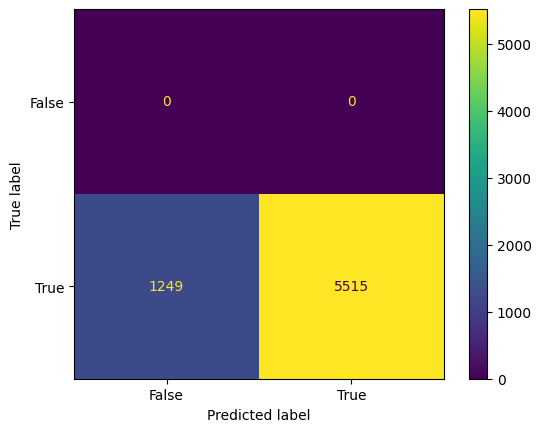

In [50]:
# Displaying Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix = cm_RF, display_labels = [False, True]).plot()
plt.show()

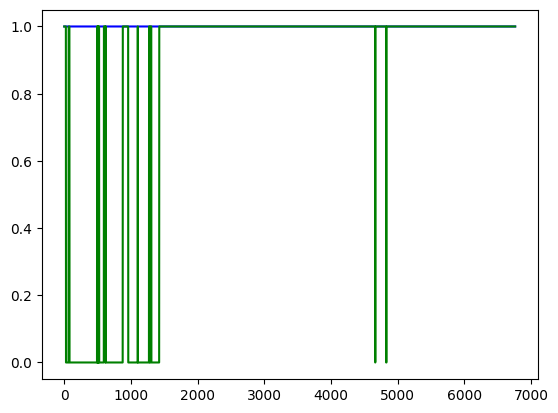

In [51]:
plt.plot(Y_test5, color = 'blue', label = 'Actual')
plt.plot(P_pred, color  = 'green', label = 'Predicted')

#### ***ADA-Boost Classifier***

In [69]:
# Creating an object for ADA-Boost Classifier with learning-rate of 0.8 and 200 estimators

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=0)

In [70]:
# Fitting ADA-Boost classifier on training dataset with TimeSeriesSplit cross-validation
tcsv1 = TimeSeriesSplit(n_splits=5)
for tr_index, val_index in tcsv1.split(X_seq):
  print(tr_index, val_index)
  ada.fit(X5_scaled, Y5)

[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]


In [75]:
# predicting values using ADA-Boost Model

P_pred_ADA = ada.predict(X_test5_scaled)
P_pred_ADA = P_pred_ADA.flatten()
print(P_pred_ADA.round(5))

[1. 1. 0. ... 1. 1. 1.]


In [76]:
# creating confusion matrix

cm_ADA = confusion_matrix(Y_test5, P_pred_ADA)
cm_ADA

array([[   0,    0],
       [ 828, 5936]])

***With a substantial increase in model accuracy to 88%, the ADA-Boost algorithm has made significant progress. Based on the recall value, it can be concluded that ADA-Boost is a highly efficient model for predicting stressful situations, with a notably higher degree of accuracy.***

In [77]:
print("\n -------------Classification Report-------------\n")
print(classification_report(Y_test5, P_pred_ADA))


 -------------Classification Report-------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.88      0.93      6764

    accuracy                           0.88      6764
   macro avg       0.50      0.44      0.47      6764
weighted avg       1.00      0.88      0.93      6764



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


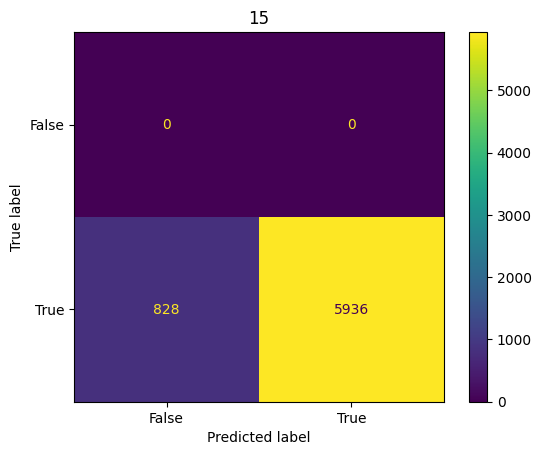

In [80]:
ConfusionMatrixDisplay(confusion_matrix = cm_ADA, display_labels = [False, True]).plot()

plt.show()


# ***Repitition trials over all the participants***

In [91]:
for j in participant_list:
    data_5C = combined1[combined1['id'] == j]
    data_5C = data_5C.sort_values('datetime')
    data_5C['datetime'] = pd.to_datetime(data_5C['datetime'])
    data_5C.set_index('datetime', inplace=True)
    data_5C.drop(['id'], axis=1, inplace=True)

    X_list = []
    Y_list = []
    Z_list = []
    EDA_list = []
    HR_list = []
    TEMP_list = []
    label_list = []

    window_size = 160     # 5 seconds
    step_size = 32        # each second continues for 32 samples

    # creating overlaping windows of size window-size 100
    for i in range(0, data_5C.shape[0] - window_size, step_size):
        x = data_5C['X'].values[i: i + window_size]
        y = data_5C['Y'].values[i: i + window_size]
        z = data_5C['Z'].values[i: i + window_size]
        eda = data_5C['EDA'].values[i: i + window_size]
        hr = data_5C['HR'].values[i: i + window_size]
        temp = data_5C['TEMP'].values[i: i + window_size]
        label = stats.mode(data_5C['label'][i: i + window_size])[0][0]

        X_list.append(x)
        Y_list.append(y)
        Z_list.append(z)
        EDA_list.append(eda)
        HR_list.append(hr)
        TEMP_list.append(temp)
        label_list.append(label)


    data5C = pd.DataFrame()
    # mean
    data5C['x_mean'] = pd.Series(X_list).apply(lambda x: x.mean())
    data5C['y_mean'] = pd.Series(Y_list).apply(lambda x: x.mean())
    data5C['z_mean'] = pd.Series(Z_list).apply(lambda x: x.mean())
    data5C['eda_mean'] = pd.Series(EDA_list).apply(lambda x: x.mean())
    data5C['hr_mean'] = pd.Series(HR_list).apply(lambda x: x.mean())
    data5C['temp_mean'] = pd.Series(TEMP_list).apply(lambda x: x.mean())

    # std dev
    data5C['eda_std'] = pd.Series(EDA_list).apply(lambda x: x.std())
    data5C['hr_std'] = pd.Series(HR_list).apply(lambda x: x.std())
    data5C['temp_std'] = pd.Series(TEMP_list).apply(lambda x: x.std())

    # min
    data5C['eda_min'] = pd.Series(EDA_list).apply(lambda x: x.min())
    data5C['hr_min'] = pd.Series(HR_list).apply(lambda x: x.std())
    data5C['temp_min'] = pd.Series(TEMP_list).apply(lambda x: x.std())

    # max
    data5C['eda_max'] = pd.Series(EDA_list).apply(lambda x: x.max())
    data5C['hr_max'] = pd.Series(HR_list).apply(lambda x: x.max())
    data5C['temp_max'] = pd.Series(TEMP_list).apply(lambda x: x.max())

    # energy
    data5C['eda_energy'] = pd.Series(EDA_list).apply(lambda x: np.sum(x**2)/32)
    data5C['hr_energy'] = pd.Series(HR_list).apply(lambda x: np.sum(x**2)/32)
    data5C['temp_energy'] = pd.Series(TEMP_list).apply(lambda x: np.sum(x**2/32))

    # RMS

    data5C['eda_rms'] = pd.Series(EDA_list).apply(lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x)))))
    data5C['hr_rms'] = pd.Series(HR_list).apply(lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x)))))
    data5C['temp_rms'] = pd.Series(TEMP_list).apply(lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x)))))

    X_list_fft = pd.Series(X_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
    Y_list_fft = pd.Series(Y_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
    Z_list_fft = pd.Series(Z_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
    EDA_list_fft = pd.Series(EDA_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
    HR_list_fft = pd.Series(HR_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])
    TEMP_list_fft = pd.Series(TEMP_list).apply(lambda x: np.abs(np.fft.fft(x))[0:32])


    # Statistical Features on raw x, y and z in frequency domain
    # FFT mean
    data5C['X_mean_fft'] = pd.Series(X_list_fft).apply(lambda x: x.mean())
    data5C['Y_mean_fft'] = pd.Series(Y_list_fft).apply(lambda x: x.mean())
    data5C['Z_mean_fft'] = pd.Series(Z_list_fft).apply(lambda x: x.mean())
    data5C['EDA_mean_fft'] = pd.Series(EDA_list_fft).apply(lambda x: x.mean())
    data5C['HR_mean_fft'] = pd.Series(HR_list_fft).apply(lambda x: x.mean())
    data5C['TEMP_mean_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: x.mean())

    # FFT min
    data5C['EDA_min_fft'] = pd.Series(EDA_list_fft).apply(lambda x: x.min())
    data5C['HR_min_fft'] = pd.Series(HR_list_fft).apply(lambda x: x.min())
    data5C['TEMP_min_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: x.min())

    # FFT max
    data5C['EDA_mean_fft'] = pd.Series(EDA_list_fft).apply(lambda x: x.max())
    data5C['HR_max_fft'] = pd.Series(HR_list_fft).apply(lambda x: x.max())
    data5C['TEMP_max_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: x.max())

    # FFT energy
    data5C['EDA_energy_fft'] = pd.Series(EDA_list_fft).apply(lambda x: np.sum(x**2)/32)
    data5C['HR_energy_fft'] = pd.Series(HR_list_fft).apply(lambda x: np.sum(x**2)/32)
    data5C['TEMP_energy_fft'] = pd.Series(TEMP_list_fft).apply(lambda x: np.sum(x**2/32))

    X = data5C.copy()
    y = label_list.copy()
    print(X.shape, len(y))



    training_frac = int(X.shape[0]*0.75)
    train_df = X.iloc[:training_frac,:]
    test_df = X.iloc[training_frac:,:]
    X5, Y5 = train_df.iloc[:,:-1], y[:training_frac]
    X_test5, Y_test5 = test_df.iloc[:,:-1], y[training_frac:]
    Y5 = np.array(Y5)
    Y_test5 = np.array(Y_test5)


    scalarRFC = StandardScaler()
    X5_scaled = scalarRFC.fit_transform(X5)
    X_test5_scaled = scalarRFC.transform(X_test5)


    ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=0)
    tcsv1 = TimeSeriesSplit(n_splits=5)
    for tr_index, val_index in tcsv1.split(X_seq):
      print(tr_index, val_index)
      ada.fit(X5_scaled, Y5)


    P_pred_ADA = ada.predict(X_test5_scaled)
    P_pred_ADA = P_pred_ADA.flatten()


    print("\n -------------Classification Report for "+ str(j) + "-------------\n")
    print(classification_report(Y_test5, P_pred_ADA))


    cm_ADA = confusion_matrix(Y_test5, P_pred_ADA)


    # ConfusionMatrixDisplay(confusion_matrix = cm_ADA, display_labels = [False, True]).plot()
    # plt.title(j)
    # plt.show()

(9656, 35) 9656
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for 15-------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.99      1.00      2414

    accuracy                           0.99      2414
   macro avg       0.50      0.50      0.50      2414
weighted avg       1.00      0.99      1.00      2414



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(27056, 35) 27056
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for 5C-------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.88      0.93      6764

    accuracy                           0.88      6764
   macro avg       0.50      0.44      0.47      6764
weighted avg       1.00      0.88      0.93      6764



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(25794, 35) 25794
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for 6B-------------

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      6449

    accuracy                           1.00      6449
   macro avg       1.00      1.00      1.00      6449
weighted avg       1.00      1.00      1.00      6449

(18476, 35) 18476
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 1352

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(43037, 35) 43037
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for 7A-------------

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       600
         1.0       0.95      1.00      0.97     10160

    accuracy                           0.95     10760
   macro avg       0.97      0.52      0.52     10760
weighted avg       0.95      0.95      0.92     10760

(7916, 35) 7916
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(19016, 35) 19016
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for BG-------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      1.00      1.00      4754

    accuracy                           1.00      4754
   macro avg       0.50      0.50      0.50      4754
weighted avg       1.00      1.00      1.00      4754



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(25436, 35) 25436
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for CE-------------

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      6359

    accuracy                           1.00      6359
   macro avg       1.00      1.00      1.00      6359
weighted avg       1.00      1.00      1.00      6359

(28376, 35) 28376
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 1352

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(46491, 35) 46491
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 10141 10142 10143] [10144 10145 10146 ... 13522 13523 13524]
[    0     1     2 ... 13522 13523 13524] [13525 13526 13527 ... 16903 16904 16905]
[    0     1     2 ... 16903 16904 16905] [16906 16907 16908 ... 20284 20285 20286]

 -------------Classification Report for E4-------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5340
         1.0       0.47      0.77      0.59      6283

    accuracy                           0.41     11623
   macro avg       0.24      0.38      0.29     11623
weighted avg       0.26      0.41      0.32     11623

(17156, 35) 17156
[   0    1    2 ... 3379 3380 3381] [3382 3383 3384 ... 6760 6761 6762]
[   0    1    2 ... 6760 6761 6762] [ 6763  6764  6765 ... 10141 10142 10143]
[    0     1     2 ... 1014